# Dependencies

In [102]:
import random
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from modAL.models import ActiveLearner
from modAL.models import Committee
from modAL.disagreement import vote_entropy_sampling
from modAL.uncertainty import classifier_uncertainty
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense
from keras.activations import relu
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sympy import pretty_print as pp, latex
from scipy.spatial import ConvexHull
from itertools import product


# Data Import

In [85]:
startDat = pd.read_csv("startDatCont.csv", header=None);
pool = pd.read_csv("poolCont.csv", header=None);
testDat = pd.read_csv("testCont.csv", header=None)

In [86]:
startDat5= startDat[0:5];

In [87]:
startDat = startDat.to_numpy()
startDat5 = startDat5.to_numpy()
pool = pool.to_numpy()
testDat = testDat.to_numpy()

# Helper Functions

In [88]:
def pbI2ppts(conc_tuple, ksp=1.4*10**(-8)):
    """ 
    oracle for if concentration tuple describes an point in space that 
    is soluble (False) or insoluble (True) - conc_tuple should be of form
    [Pb2+, I-]
    """
    if conc_tuple[0]*conc_tuple[1] == 0:
        return 0
    else:
        if (conc_tuple[1] >= sqrt(ksp/conc_tuple[0])):
            return 1
        elif (conc_tuple[1] < sqrt(ksp/conc_tuple[0])):
            return 0
        else:
            return print("error")

In [89]:
def pbI2Imbppts(conc_tuple, ksp=5*10**(-8)):
    """ 
    oracle for if concentration tuple describes an point in space that 
    is soluble (False) or insoluble (True) - conc_tuple should be of form
    [Pb2+, I-]
    """
    if conc_tuple[0]*conc_tuple[1] == 0:
        return 0
    else:
        if (conc_tuple[1] >= sqrt(ksp/conc_tuple[0])):
            return 1
        elif (conc_tuple[1] < sqrt(ksp/conc_tuple[0])):
            return 0
        else:
            return print("error")

In [90]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [91]:
def noisy_oracle2D(conc_tuple, noise_pc, ksp=1.4*10**(-8)):
    outcome = np.random.choice([1, -1], p=[(1- noise_pc), noise_pc])
    if outcome == 1 and pbI2ppts(conc_tuple) == 1:
        return 1
    elif outcome == 1 and pbI2ppts(conc_tuple) == 0:
        return 0
    elif outcome == -1 and pbI2ppts(conc_tuple) == 1:
        return 0
    elif outcome == -1 and pbI2ppts(conc_tuple) == 0:
        return 1

In [92]:
def noisy_oracleImb2D(conc_tuple, noise_pc, ksp=5*10**(-8)):
    outcome = np.random.choice([1, -1], p=[(1- noise_pc), noise_pc])
    if outcome == 1 and pbI2Imbppts(conc_tuple) == 1:
        return 1
    elif outcome == 1 and pbI2Imbppts(conc_tuple) == 0:
        return 0
    elif outcome == -1 and pbI2Imbppts(conc_tuple) == 1:
        return 0
    elif outcome == -1 and pbI2Imbppts(conc_tuple) == 0:
        return 1

In [93]:
def plot_metric(met_history, metric=""):
    fig, ax = plt.subplots(figsize=(8.5, 4), dpi=130)

    ax.plot(met_history)
    ax.scatter(range(len(met_history)), met_history, s=13)

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)

    ax.set_title('Incremental Classification ' + str(metric))
    ax.set_xlabel('Query Iteration')
    ax.set_ylabel('Classification ' + str(metric))

    plt.show()

In [94]:
ystartDat = [pbI2ppts(j) for j in startDat]
ystartDat5 = [pbI2ppts(j) for j in startDat5]
ypool = [pbI2ppts(j) for j in pool]
ytest = [pbI2ppts(j) for j in testDat]

In [95]:
 svm = SVC(kernel='rbf', probability=True)

# Grid Search

In [1756]:
gridDat2D = pd.read_csv('gridDat2D.csv', header=None)
gridDat2D = gridDat2D.to_numpy()

In [1757]:
def run_gs_al(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for index in range(N_QUERIES):
        newX, newY = t_pool[index].reshape(1, -1), [noisy_oracle2D(t_pool[index], noise_pc)]
        learner.teach(X=newX, y=newY)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    return learner, perf_hist, mse_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

In [1880]:
def run_gs_alImb(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for index in range(N_QUERIES):
        newX, newY = t_pool[index].reshape(1, -1), [noisy_oracleImb2D(t_pool[index], noise_pc)]
        learner.teach(X=newX, y=newY)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [1727]:
init_learner5 = ActiveLearner(svm, X_training=startDat5, y_training=ystartDat5)
gs_learner, gs_perf_hist, gs_mse_hist = run_gs_al(init_learner5, gridDat2D, testDat, 0)

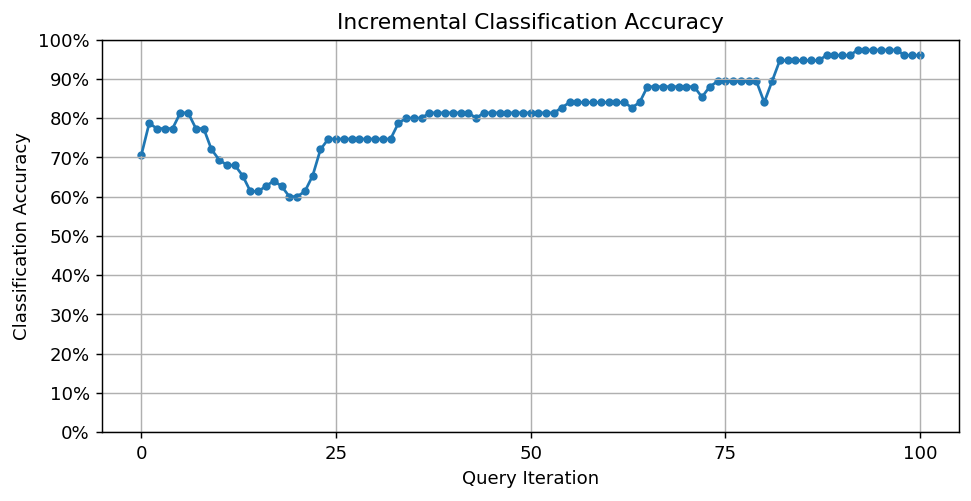

In [1479]:
plot_metric(gs_perf_hist, 'Accuracy')

## Noise

### 10%

In [1822]:
init_learner10pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.1) for i in startDat5])
gs_learner10pc, gs_perf_hist10pc, gs_mse_hist10pc = run_gs_al(init_learner10pc5, gridDat2D, testDat, 0.1)

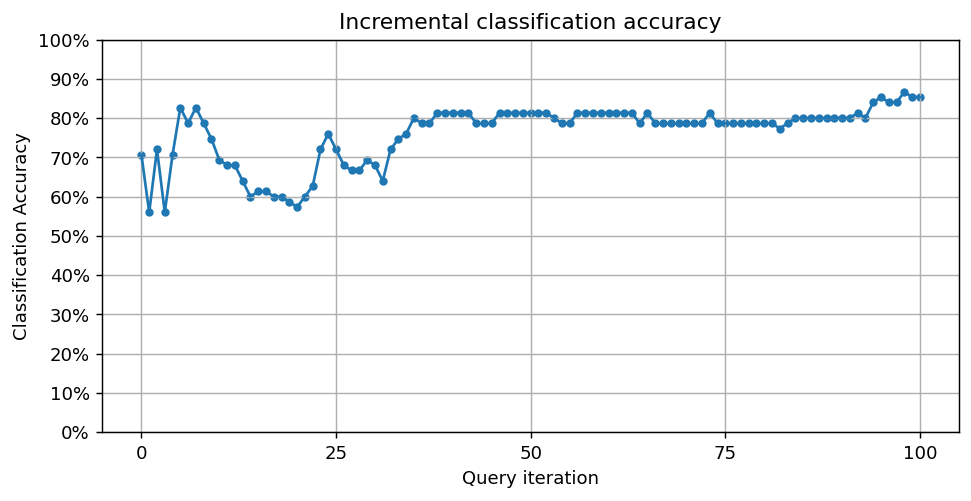

In [1823]:
plot_acc(gs_perf_hist10pc)

### 20%

In [1824]:
init_learner20pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.2) for i in startDat5])
gs_learner20pc, gs_perf_hist20pc, gs_mse_hist20pc = run_gs_al(init_learner20pc5, gridDat2D, testDat, 0.2)

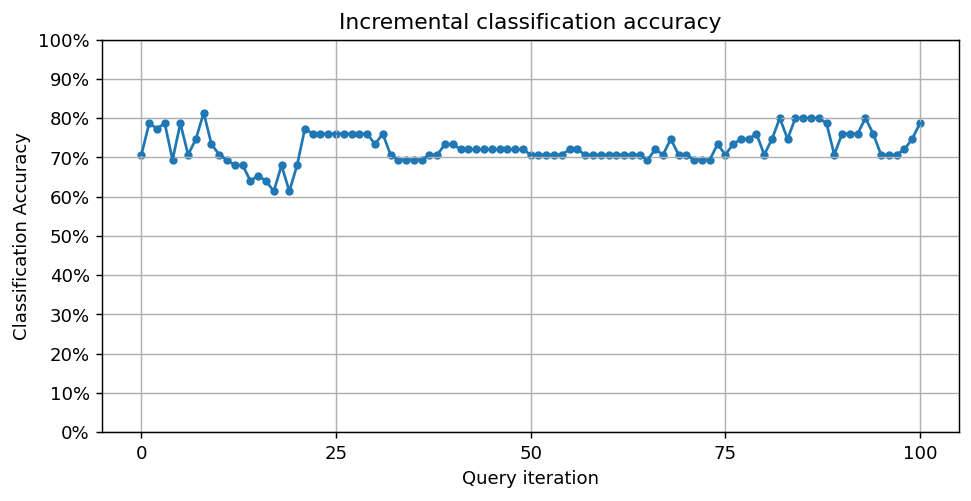

In [1825]:
plot_acc(gs_perf_hist20pc)

### 30%

In [1826]:
init_learner30pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.3) for i in startDat5])
gs_learner30pc, gs_perf_hist30pc, gs_mse_hist30pc = run_gs_al(init_learner30pc5, gridDat2D, testDat, 0.3)

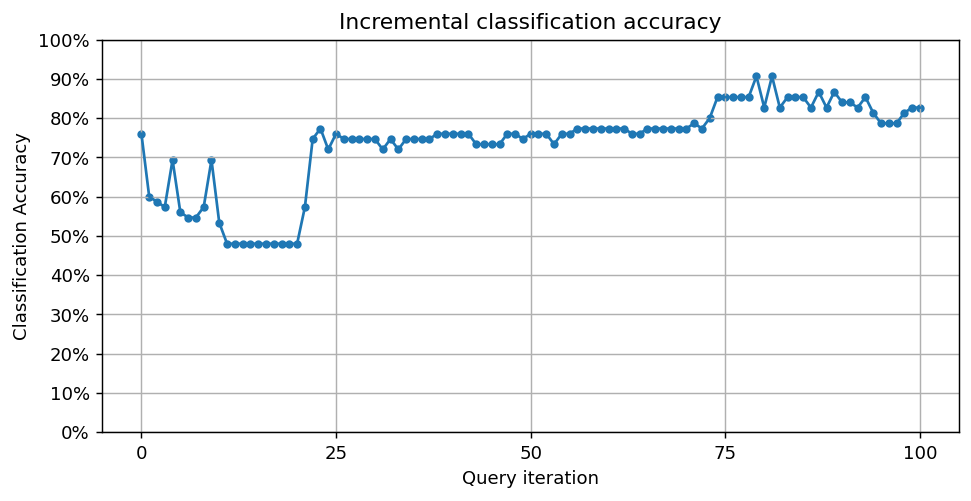

In [1827]:
plot_acc(gs_perf_hist30pc)

### 40%

In [1828]:
init_learner40pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.4) for i in startDat5])
gs_learner40pc, gs_perf_hist40pc, gs_mse_hist40pc = run_gs_al(init_learner40pc5, gridDat2D, testDat, 0.4)

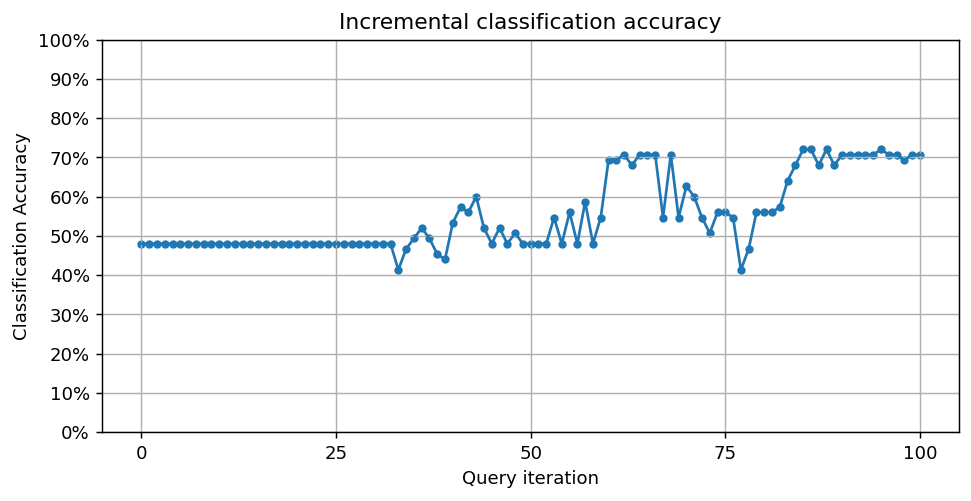

In [1829]:
plot_acc(gs_perf_hist40pc)

### 50%

In [1835]:
init_learner50pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.5) for i in startDat5])
gs_learner50pc, gs_perf_hist50pc, gs_mse_hist50pc = run_gs_al(init_learner50pc5, gridDat2D, testDat, 0.5)

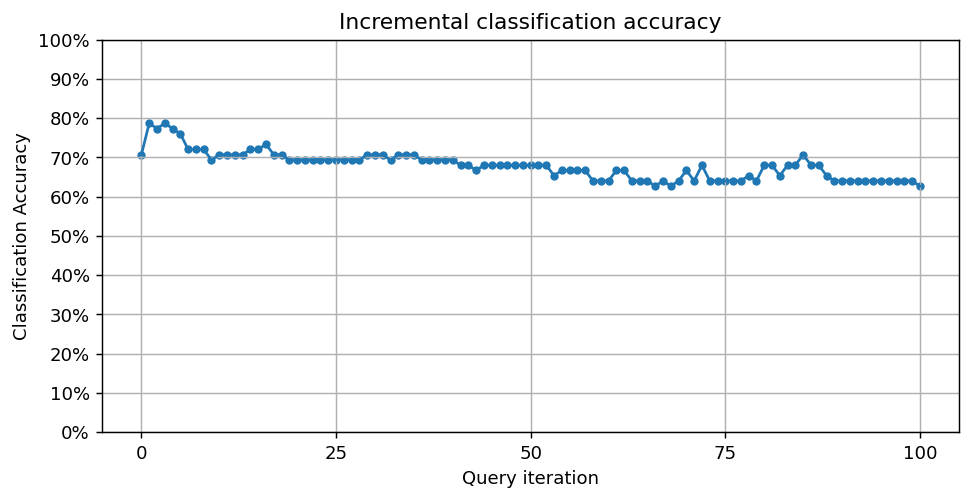

In [1836]:
plot_acc(gs_perf_hist50pc)

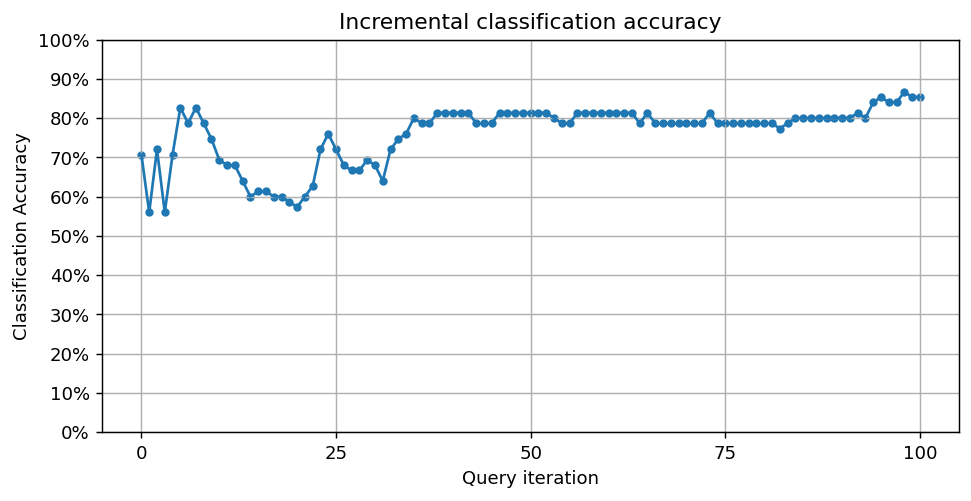

In [1832]:
plot_acc(gs_perf_hist10pc)

## Imbalanced

In [1896]:
del gs_learnerimb, gs_perf_histImb, gs_mse_histImb, gs_mcc_histImb

In [1897]:
init_learner5imb = ActiveLearner(svm, X_training=startDat5, y_training=[pbI2Imbppts(i) for i in startDat5])
gs_learnerimb, gs_perf_histImb, gs_mse_histImb, gs_mcc_histImb = run_gs_alImb(init_learner5imb, gridDat2D, testDat, 0)

/home/wborrelli/mambaforge/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/wborrelli/mambaforge/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


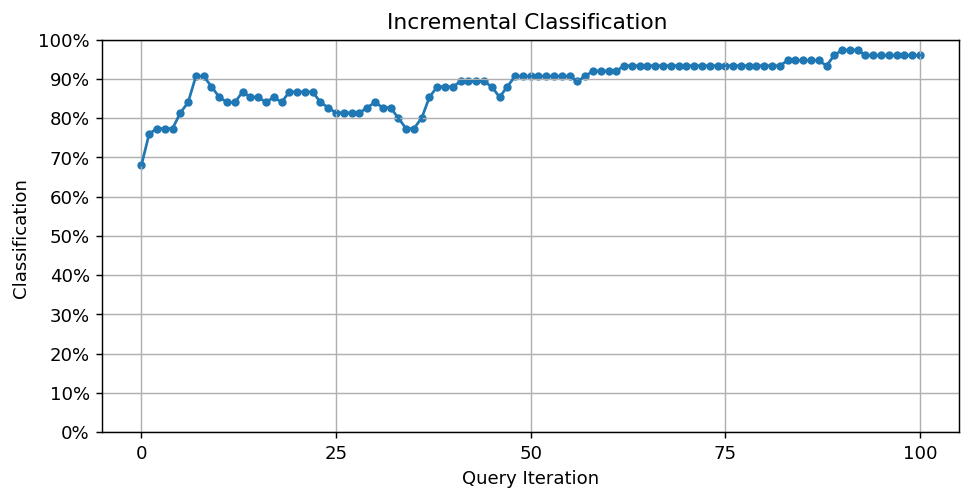

In [1898]:
plot_metric(gs_perf_histImb)

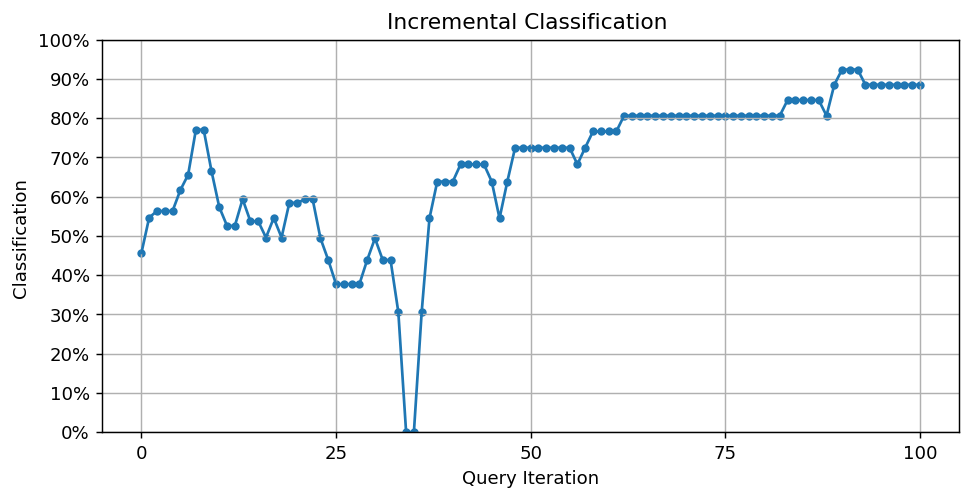

In [1899]:
plot_metric(gs_mcc_histImb)

# Serial Dilution

In [2000]:
rayDat2D = pd.read_csv('rayPts2D.csv', header=None)
rayDat2D = rayDat2D.to_numpy()

In [1763]:
def run_rd_al(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for index in range(N_QUERIES):
        newX, newY = t_pool[index].reshape(1, -1), [noisy_oracle2D(t_pool[index], noise_pc)]
        learner.teach(X=newX, y=newY)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    return learner, perf_hist, mse_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

In [1900]:
def run_rd_alImb(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for index in range(N_QUERIES):
        newX, newY = t_pool[index].reshape(1, -1), [noisy_oracleImb2D(t_pool[index], noise_pc)]
        learner.teach(X=newX, y=newY)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [1729]:
init_learner5 = ActiveLearner(svm, X_training=startDat5, y_training=ystartDat5)
rd_learner, rd_perf_hist, rd_mse_hist = run_rd_al(init_learner5, rayDat2D, testDat, 0)

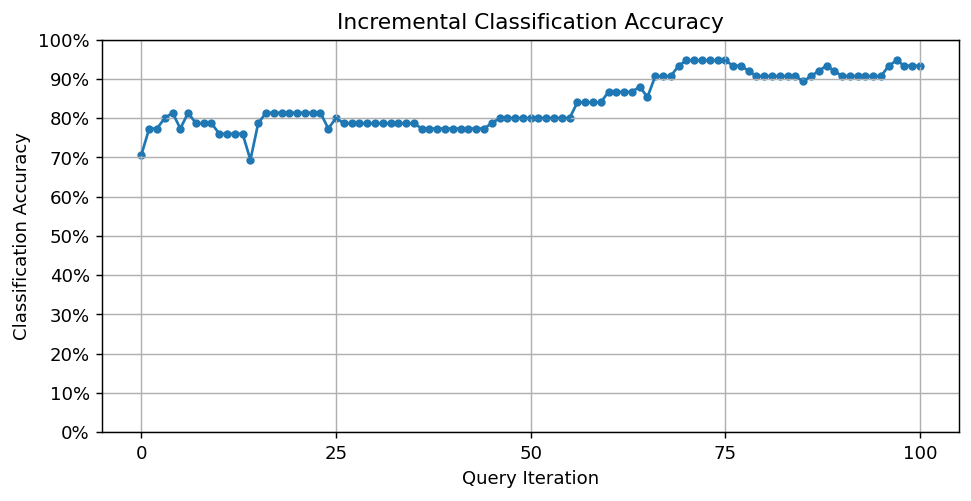

In [1730]:
plot_metric(rd_perf_hist, "Accuracy")

In [1994]:
len(rayDat2D[:,1])

100

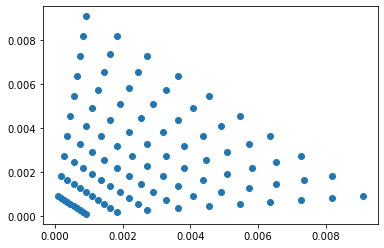

In [2006]:
plt.scatter(rayDat2D[:,0], rayDat2D[:,1])

In [2025]:
rayDat2D[0]

array([9.09090909e-05, 9.09090909e-04])

In [2026]:
rayDat2DShuffle[0]

array([0.00018182, 0.00181818])

In [2033]:
rayDat2DShuffle = rayDat2D.copy()
rayDat2DShuffle = np.take(rayDat2DShuffle,np.random.permutation(rayDat2DShuffle.shape[0]),axis=0,out=rayDat2DShuffle)

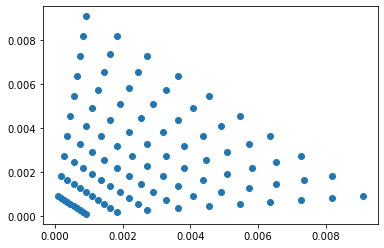

In [2034]:
plt.scatter(rayDat2DShuffle[:,0], rayDat2DShuffle[:,1])

In [2035]:
del rd_learner2, rd_perf_hist2, rd_mse_hist2

In [2036]:
init_learner52 = ActiveLearner(svm, X_training=startDat5, y_training=ystartDat5)
rd_learner2, rd_perf_hist2, rd_mse_hist2 = run_rd_al(init_learner52, rayDat2DShuffle, testDat, 0)

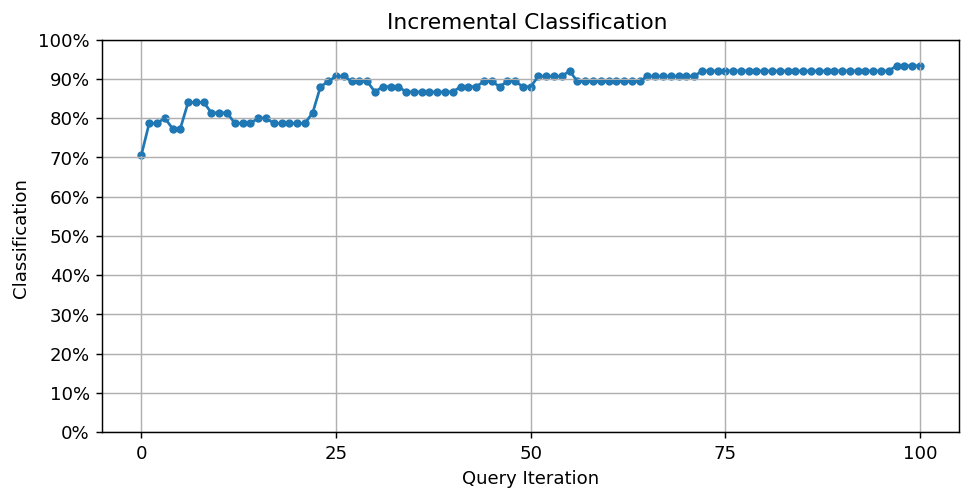

In [2038]:
plot_metric(rd_perf_hist2)

## Noise

### 10%

In [1508]:
init_learner10pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.1) for i in startDat5])
rd_learner10pc, rd_perf_hist10pc, rd_mse_hist10pc = run_rd_al(init_learner10pc5, rayDat2D, testDat, 0.1)

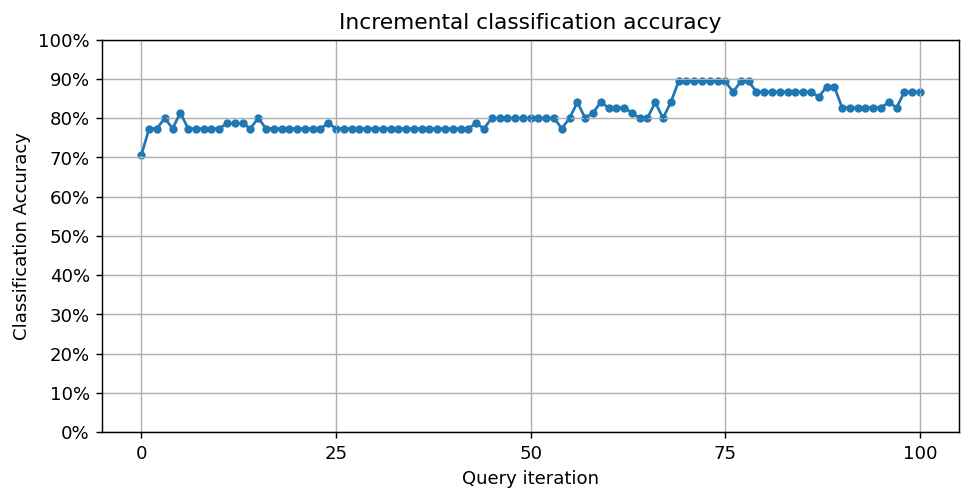

In [1511]:
plot_acc(rd_perf_hist10pc)

### 20%

In [1494]:
init_learner20pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.2) for i in startDat5])
rd_learner20pc, rd_perf_hist20pc, rd_mse_hist20pc = run_rd_al(init_learner20pc5, rayDat2D, testDat, 0.2)

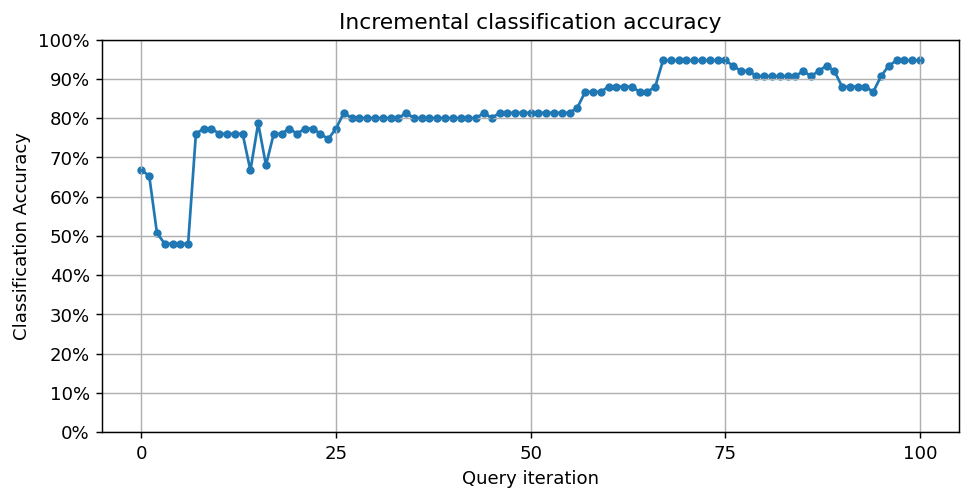

In [886]:
plot_acc(rd_perf_hist20pc)

### 30%

In [1495]:
init_learner30pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.3) for i in startDat5])
rd_learner30pc, rd_perf_hist30pc, rd_mse_hist30pc = run_rd_al(init_learner30pc5, rayDat2D, testDat, 0.3)

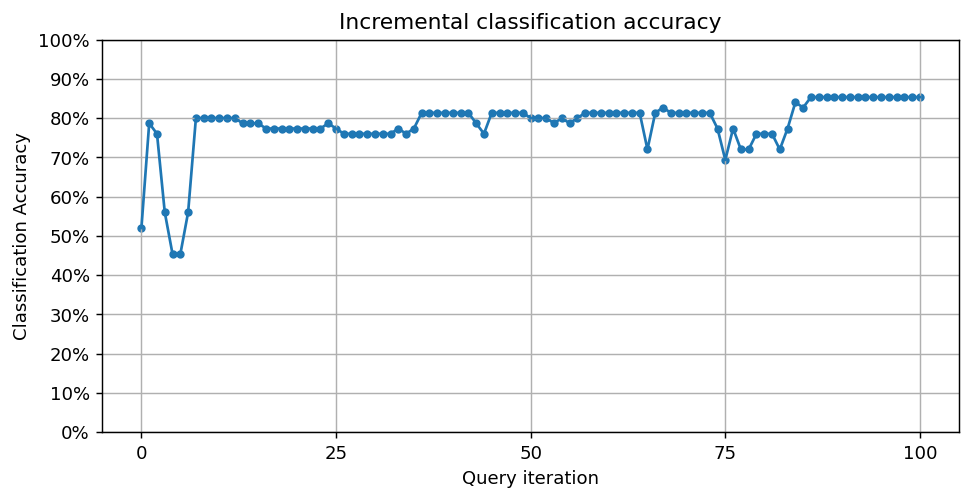

In [888]:
plot_acc(rd_perf_hist30pc)

### 40%

In [1496]:
init_learner40pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.4) for i in startDat5])
rd_learner40pc, rd_perf_hist40pc, rd_mse_hist40pc = run_rd_al(init_learner40pc5, rayDat2D, testDat, 0.4)

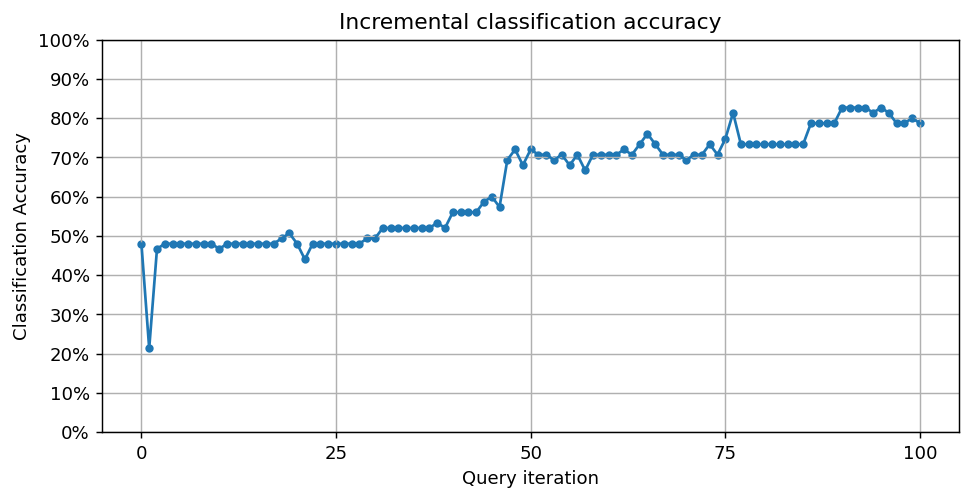

In [890]:
plot_acc(rd_perf_hist40pc)

### 50%

In [1498]:
init_learner50pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.5) for i in startDat5])
rd_learner50pc, rd_perf_hist50pc, rd_mse_hist50pc = run_rd_al(init_learner50pc5, rayDat2D, testDat, 0.5)

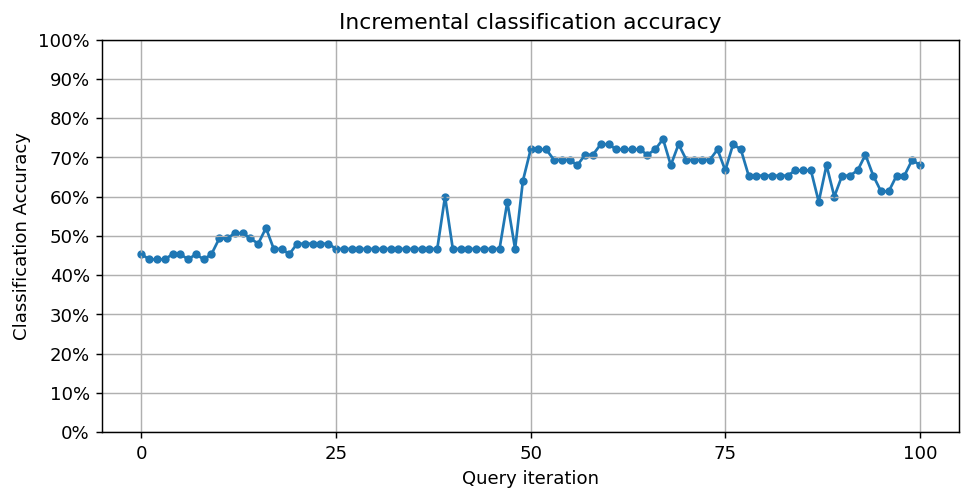

In [1513]:
plot_acc(rd_perf_hist50pc)

## Imbalanced

In [1901]:
init_learner5Imb = ActiveLearner(svm, X_training=startDat5, y_training=[pbI2Imbppts(i) for i in startDat5])
rd_learnerImb, rd_perf_histImb, rd_mse_histImb, rd_mcc_histImb = run_rd_alImb(init_learner5Imb, rayDat2D, testDat, 0)

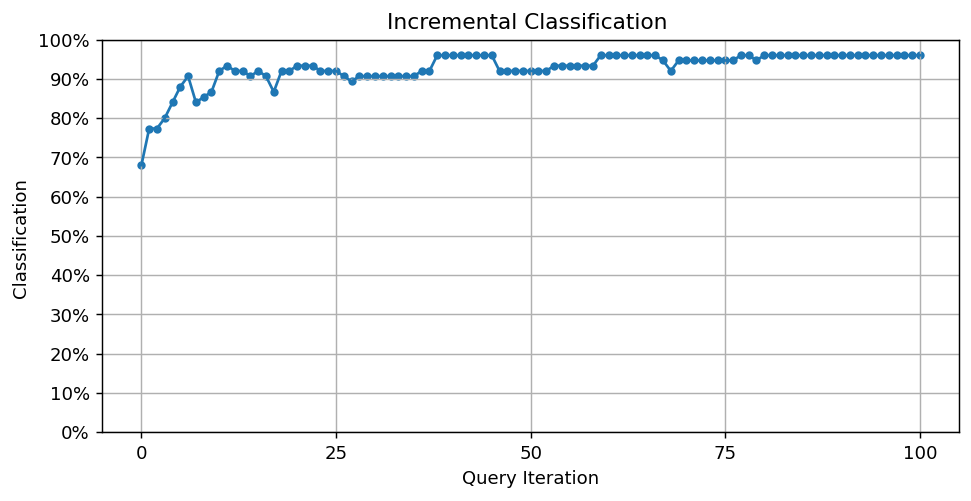

In [1903]:
plot_metric(rd_perf_histImb)

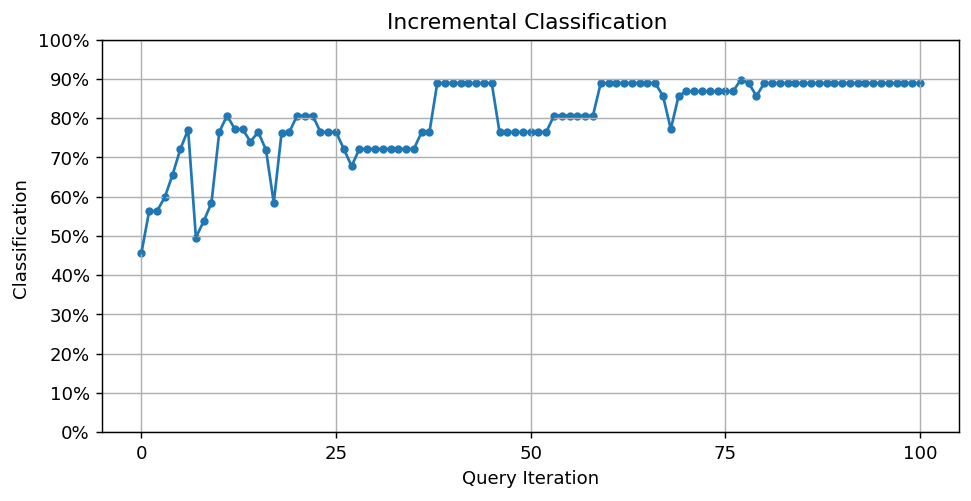

In [1904]:
plot_metric(rd_mcc_histImb)

# Random Add

In [1733]:
def run_ra_al(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    pool_indices = np.array(len(t_pool))
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for index in range(N_QUERIES):
        query_index = np.random.choice()
        newX, newY = t_pool[query_index].reshape(1, -1), [noisy_oracle2D(t_pool[query_index], noise_pc)]
        learner.teach(X=newX, y=newY)

        t_pool = np.delete(t_pool, query_index, axis=0)
        pool_indices = np.delete(pool_indices, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    del newX, newY
    return learner, perf_hist, mse_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

In [1905]:
def run_ra_alImb(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    pool_indices = np.array(len(t_pool))
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for index in range(N_QUERIES):
        query_index = np.random.choice()
        newX, newY = t_pool[query_index].reshape(1, -1), [noisy_oracle2DImb(t_pool[query_index], noise_pc)]
        learner.teach(X=newX, y=newY)

        t_pool = np.delete(t_pool, query_index, axis=0)
        pool_indices = np.delete(pool_indices, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [1974]:
init_learner5 = ActiveLearner(svm, X_training=startDat5, y_training=ystartDat5)
ra_learner, ra_perf_hist, ra_mse_hist = run_rd_al(init_learner5, pool, testDat, 0)

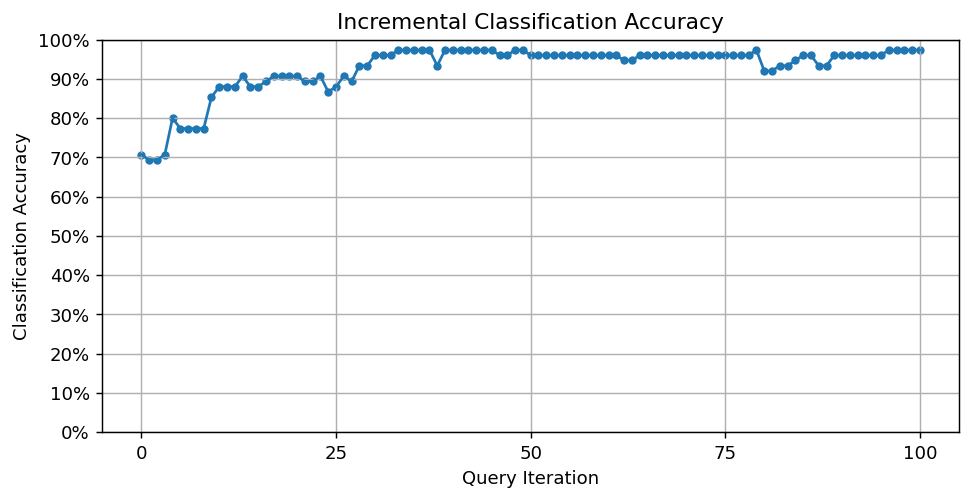

In [1406]:
plot_metric(ra_perf_hist, "Accuracy")

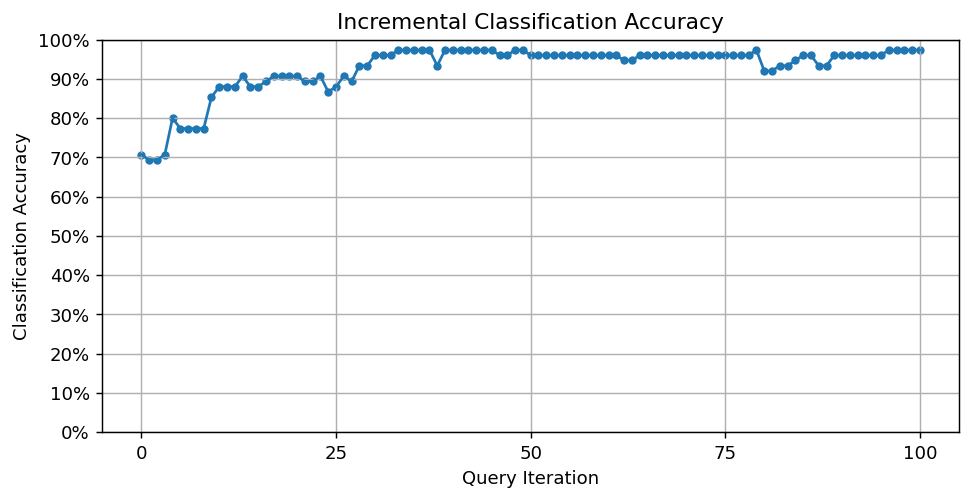

In [1975]:
plot_metric(ra_perf_hist, "Accuracy")

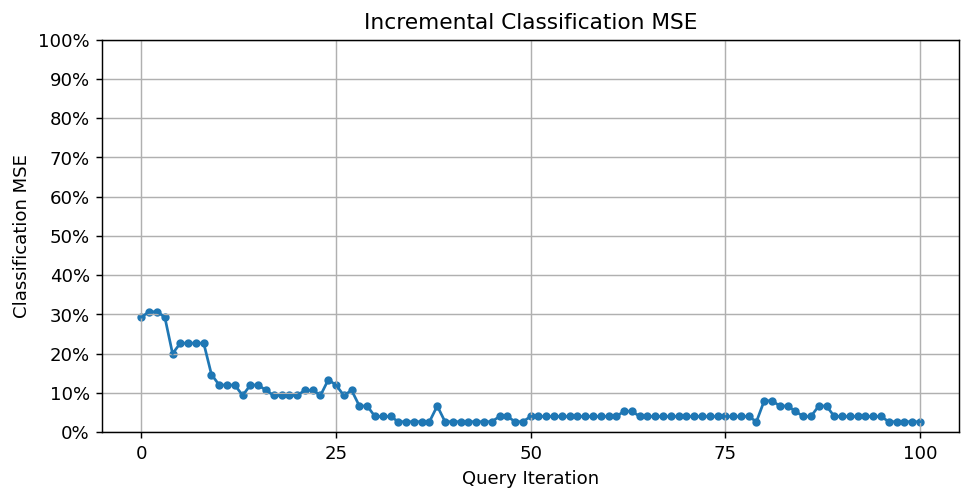

In [1407]:
plot_metric(ra_mse_hist, "MSE")

## Noise

### 10%

In [1519]:
init_learner510pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.1) for i in startDat5])
ra_learner10pc, ra_perf_hist10pc, ra_mse_hist10pc = run_rd_al(init_learner510pc, pool, testDat, 0.1)

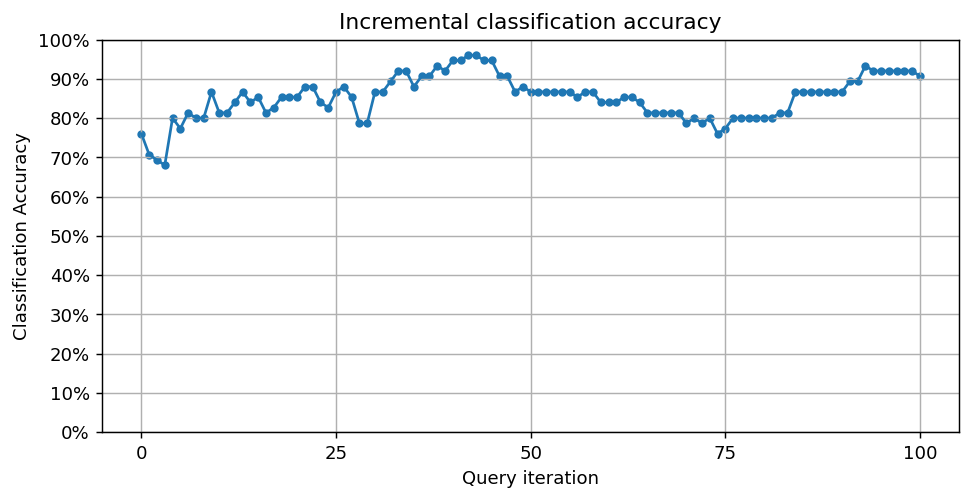

In [1521]:
plot_acc(ra_perf_hist10pc)

### 20%

In [1522]:
init_learner520pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.2) for i in startDat5])
ra_learner20pc, ra_perf_hist20pc, ra_mse_hist20pc = run_rd_al(init_learner520pc, pool, testDat, 0.2)

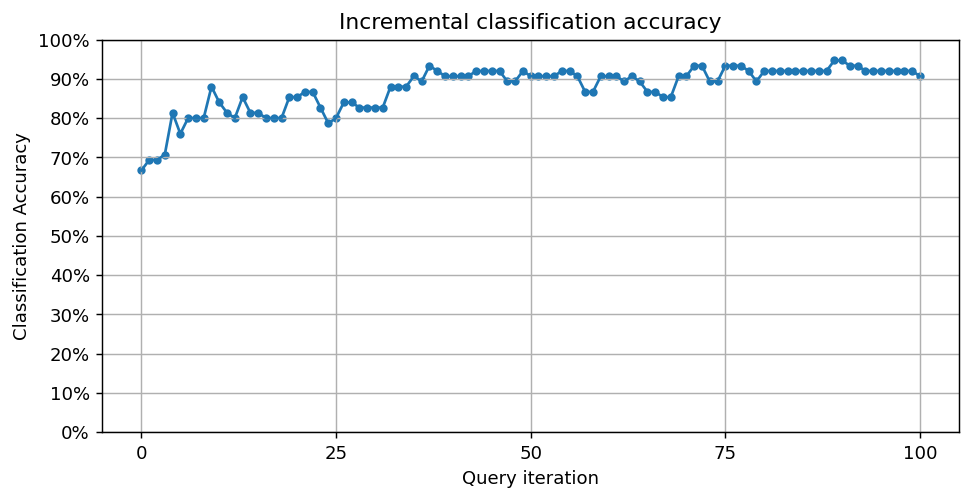

In [1123]:
plot_acc(ra_perf_hist20pc)

### 30%

In [1523]:
init_learner530pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.3) for i in startDat5])
ra_learner30pc, ra_perf_hist30pc, ra_mse_hist30pc = run_rd_al(init_learner530pc, pool, testDat, 0.3)

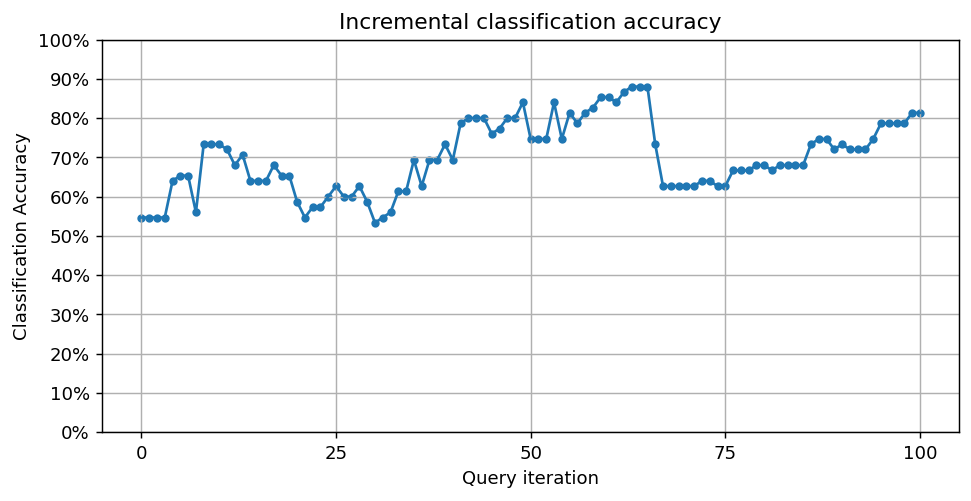

In [1125]:
plot_acc(ra_perf_hist30pc)

### 40%

In [1524]:
init_learner540pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.4) for i in startDat5])
ra_learner40pc, ra_perf_hist40pc, ra_mse_hist40pc = run_rd_al(init_learner540pc, pool, testDat, 0.4)

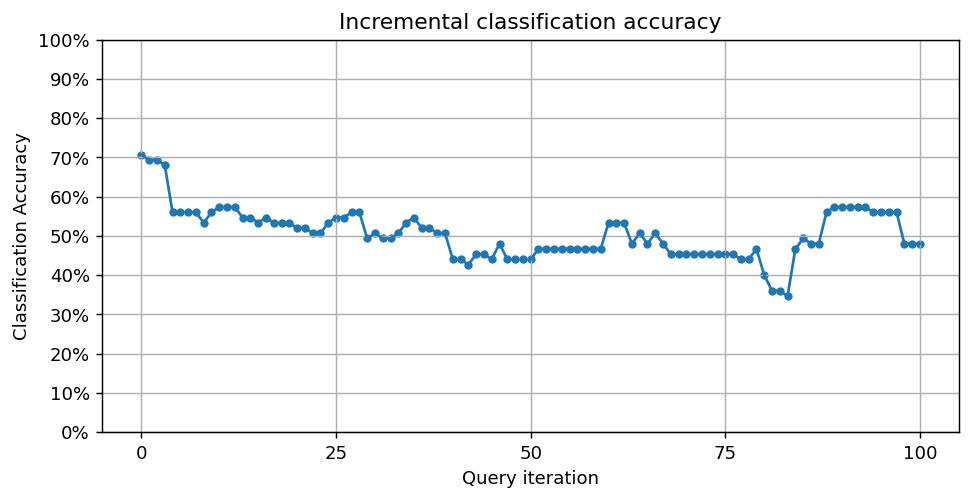

In [1127]:
plot_acc(ra_perf_hist40pc)

### 50%

In [1526]:
init_learner550pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.5) for i in startDat5])
ra_learner50pc, ra_perf_hist50pc, ra_mse_hist50pc = run_rd_al(init_learner550pc, pool, testDat, 0.5)

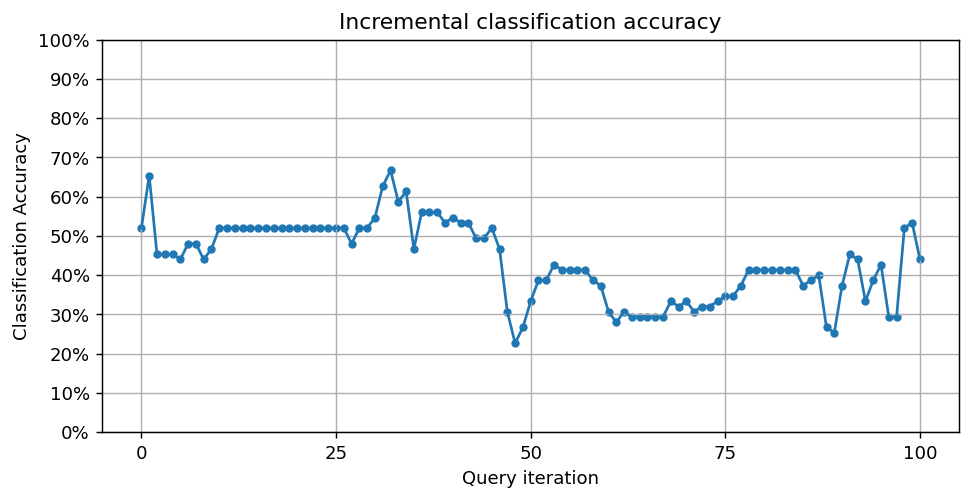

In [1129]:
plot_acc(ra_perf_hist50pc)

## Imbalanced

In [1906]:
init_learner5Imb = ActiveLearner(svm, X_training=startDat5, y_training=[pbI2Imbppts(i) for i in startDat5])
ra_learnerImb, ra_perf_histImb, ra_mse_histImb, ra_mcc_histImb = run_rd_alImb(init_learner5Imb, pool, testDat, 0)

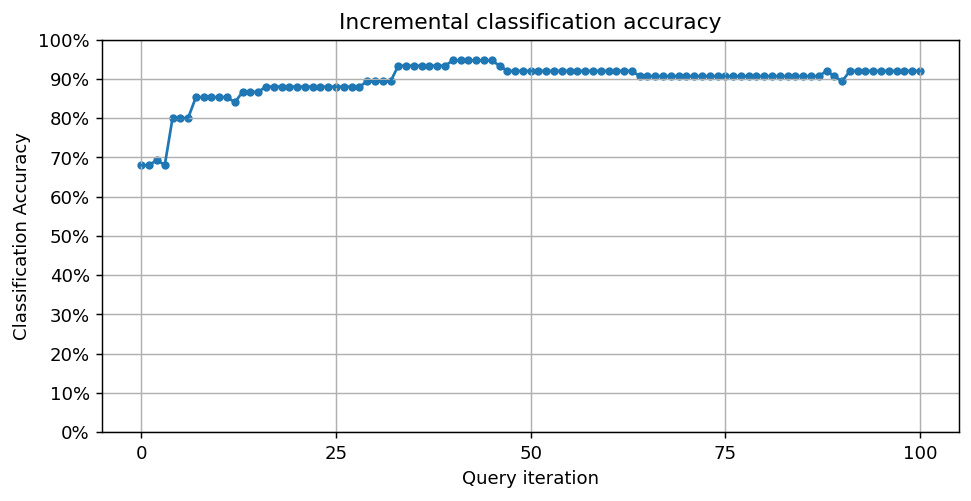

In [1907]:
plot_acc(ra_perf_histImb)

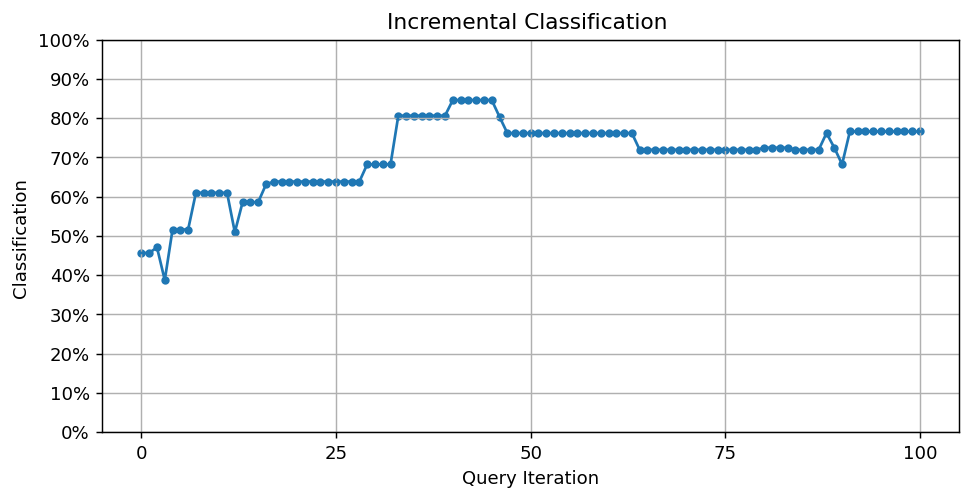

In [1908]:
plot_metric(ra_mcc_histImb)

# Uncertainty

In [1735]:
def run_u_al(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        query_index, query_instance = learner.query(t_pool)
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle2D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    return learner, perf_hist, mse_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY, query_index, query_instance

In [1909]:
def run_u_alImb(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        query_index, query_instance = learner.query(t_pool)
        newX, newY = [t_pool[int(query_index)]], [noisy_oracleImb2D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY, query_index, query_instance

## Noiseless

In [1736]:
init_learner5 = ActiveLearner(svm, X_training=startDat5, y_training=ystartDat5)
u_learner, u_perf_hist, u_mse_hist = run_u_al(init_learner5, pool, testDat, 0)

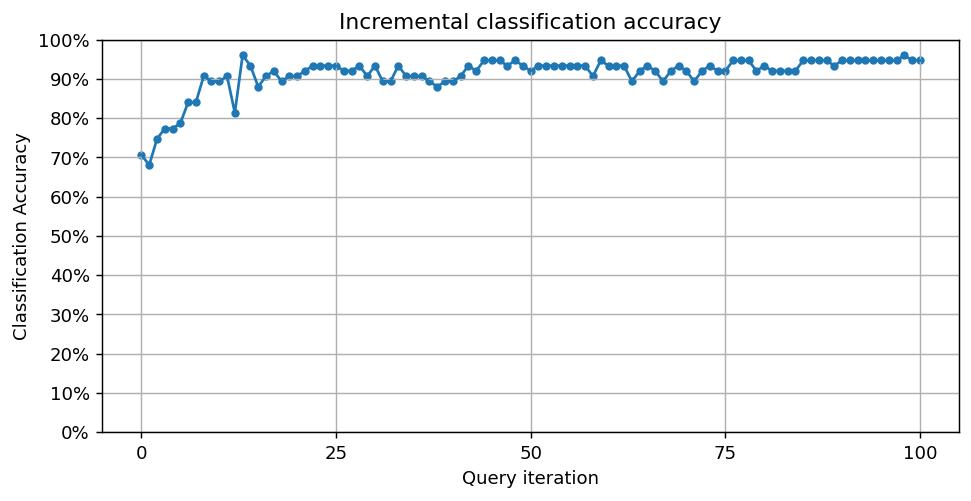

In [870]:
plot_acc(u_perf_hist)

## Noise

### 10%

In [1843]:
init_learner10pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.1) for i in startDat5])
u_learner10pc, u_perf_hist10pc, u_mse_hist10pc = run_u_al(init_learner10pc5, pool, testDat, 0.1)

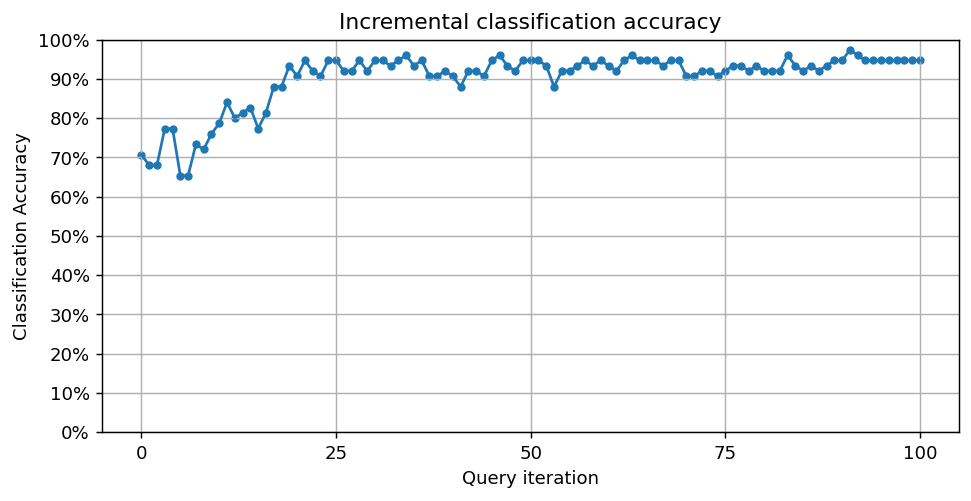

In [1844]:
plot_acc(u_perf_hist10pc)

### 20%

In [1845]:
init_learner20pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.2) for i in startDat5])
u_learner20pc, u_perf_hist20pc, u_mse_hist20pc = run_u_al(init_learner20pc5, pool, testDat, 0.2)

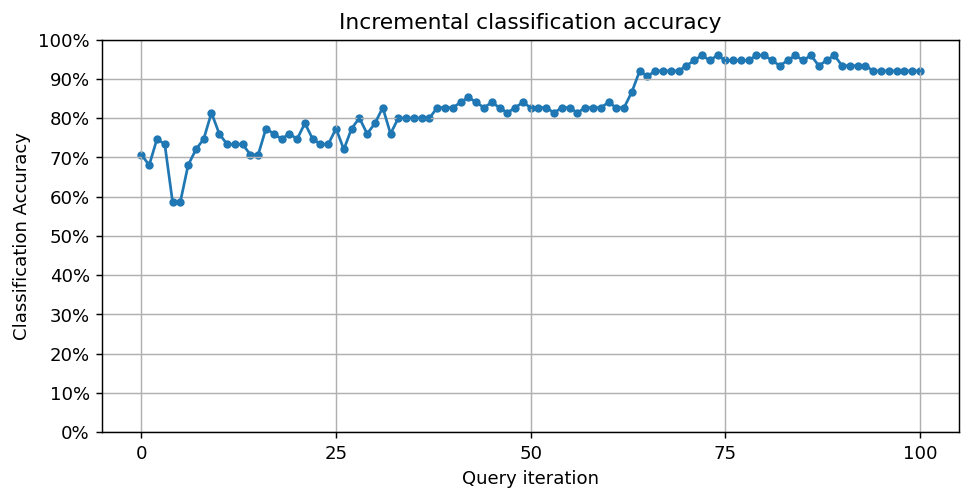

In [874]:
plot_acc(u_perf_hist20pc)

### 30%

In [1846]:
init_learner30pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.3) for i in startDat5])
u_learner30pc, u_perf_hist30pc, u_mse_hist30pc = run_u_al(init_learner30pc5, pool, testDat, 0.3)

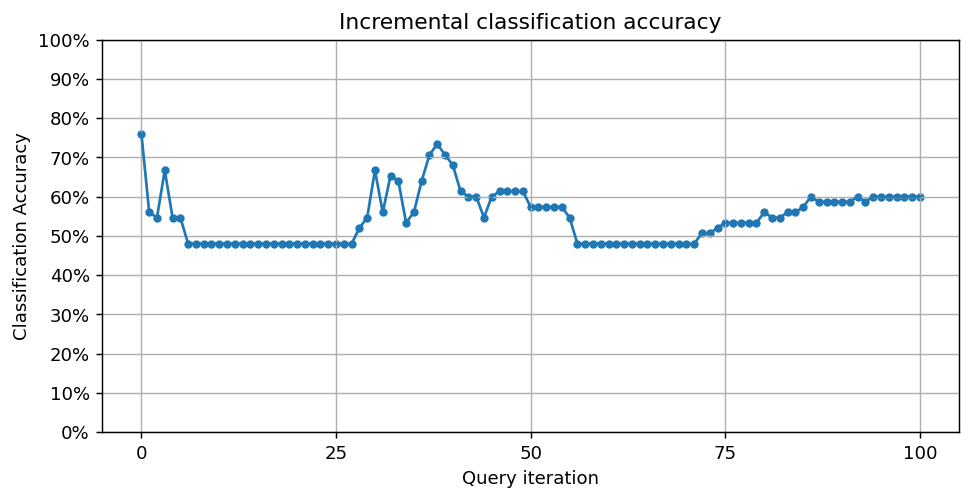

In [876]:
plot_acc(u_perf_hist30pc)

### 40%

In [1847]:
init_learner40pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.4) for i in startDat5])
u_learner40pc, u_perf_hist40pc, u_mse_hist40pc = run_u_al(init_learner40pc5, pool, testDat, 0.4)

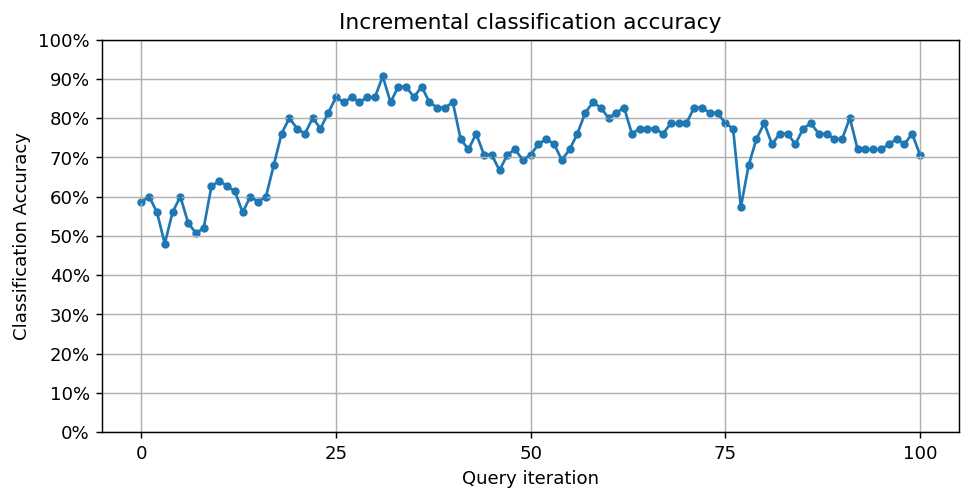

In [878]:
plot_acc(u_perf_hist40pc)

### 50%

In [1848]:
init_learner50pc5 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.5) for i in startDat5])
u_learner50pc, u_perf_hist50pc, u_mse_hist50pc = run_u_al(init_learner50pc5, pool, testDat, 0.5)

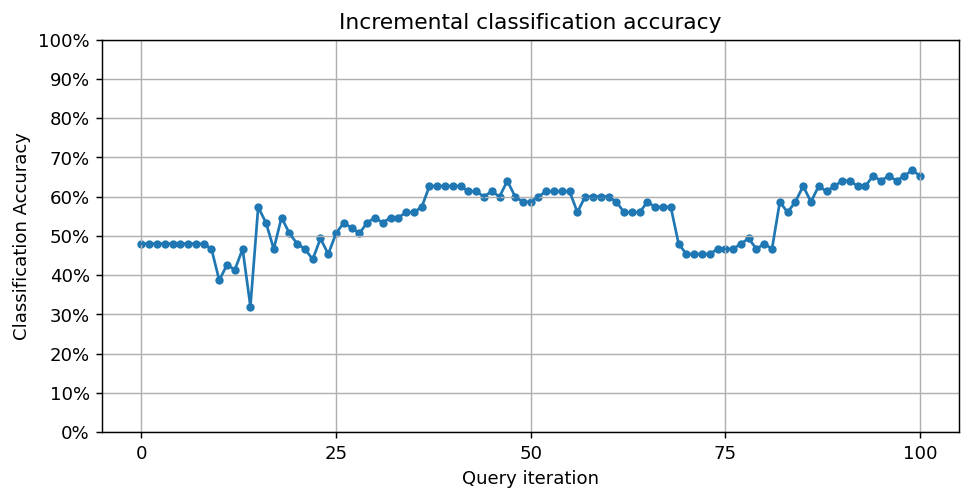

In [880]:
plot_acc(u_perf_hist50pc)

## Imbalanced

In [1910]:
init_learner5Imb = ActiveLearner(svm, X_training=startDat5, y_training=[pbI2Imbppts(i) for i in startDat5])
u_learnerImb, u_perf_histImb, u_mse_histImb, u_mcc_histImb = run_u_alImb(init_learner5Imb, pool, testDat, 0)

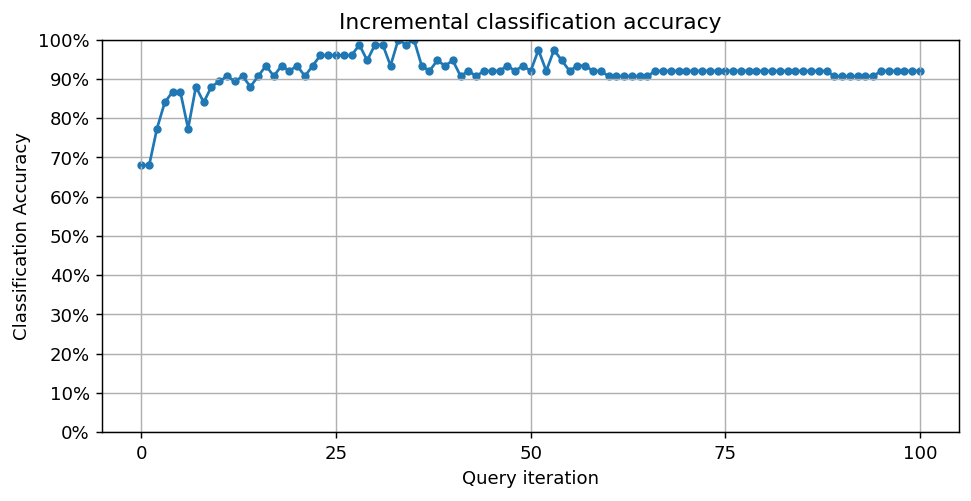

In [1781]:
plot_acc(u_perf_histImb)

# QBC

In [1783]:
def make_committee(starting_dat, noise_pc):
    l1 = ActiveLearner(svm, X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    l2 = ActiveLearner(KNeighborsClassifier(), X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    l3 = ActiveLearner(GaussianNB(), X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    l4 = ActiveLearner(RandomForestClassifier(), X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    l5 = ActiveLearner(DecisionTreeClassifier(), X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    learner_list = [l1, l2, l3, l4, l5]
    return Committee(learner_list, query_strategy=vote_entropy_sampling)
    del l1, l2, l3, l4, l5, learner_list

In [1784]:
def make_committeeImb(starting_dat, noise_pc):
    l1 = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracleImb2D(i, noise_pc) for i in starting_dat])
    l2 = ActiveLearner(KNeighborsClassifier(), X_training=startDat5, y_training=[noisy_oracleImb2D(i, noise_pc) for i in starting_dat])
    l3 = ActiveLearner(GaussianNB(), X_training=startDat5, y_training=[noisy_oracleImb2D(i, noise_pc) for i in starting_dat])
    l4 = ActiveLearner(RandomForestClassifier(), X_training=startDat5, y_training=[noisy_oracleImb2D(i, noise_pc) for i in starting_dat])
    l5 = ActiveLearner(DecisionTreeClassifier(), X_training=startDat5, y_training=[noisy_oracleImb2D(i, noise_pc) for i in starting_dat])
    learner_list = [l1, l2, l3, l4, l5]
    return Committee(learner_list, query_strategy=vote_entropy_sampling)
    del l1, l2, l3, l4, l5, learner_list

In [1785]:
def run_qbc_al(starting_committee, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    committee = starting_committee
    perf_hist = [committee.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, committee.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        query_index, query_instance = committee.query(t_pool)
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle2D(t_pool[int(query_index)], noise_pc)]
        committee.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = committee.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, committee.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    return committee, perf_hist, mse_hist
    del committee, starting_committee, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

In [1911]:
def run_qbc_alImb(starting_committee, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    committee = starting_committee
    perf_hist = [committee.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, committee.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, committee.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        query_index, query_instance = committee.query(t_pool)
        newX, newY = [t_pool[int(query_index)]], [noisy_oracleImb2D(t_pool[int(query_index)], noise_pc)]
        committee.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = committee.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, committee.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, committee.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    return committee, perf_hist, mse_hist, mcc_hist
    del committee, starting_committee, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [1740]:
init_committee = make_committee(startDat5, 0)
qbc_learner, qbc_perf_hist, qbc_mse_hist = run_qbc_al(init_committee, pool, testDat, 0)

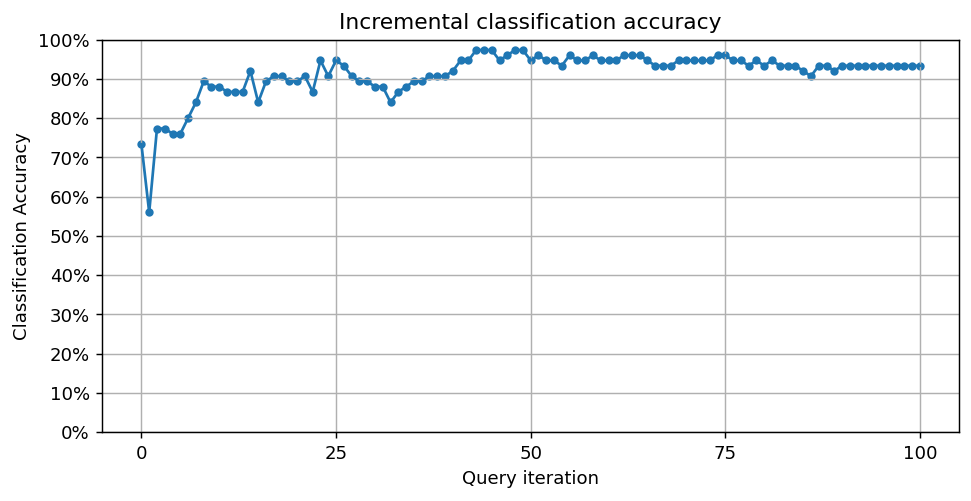

In [839]:
plot_acc(qbc_perf_hist)

## Noise

### 10%

In [1837]:
init_committee10pc = make_committee(startDat5, 0.1)
qbc_learner10pc, qbc_perf_hist10pc, qbc_mse_hist10pc = run_qbc_al(init_committee10pc, pool, testDat, 0.1)

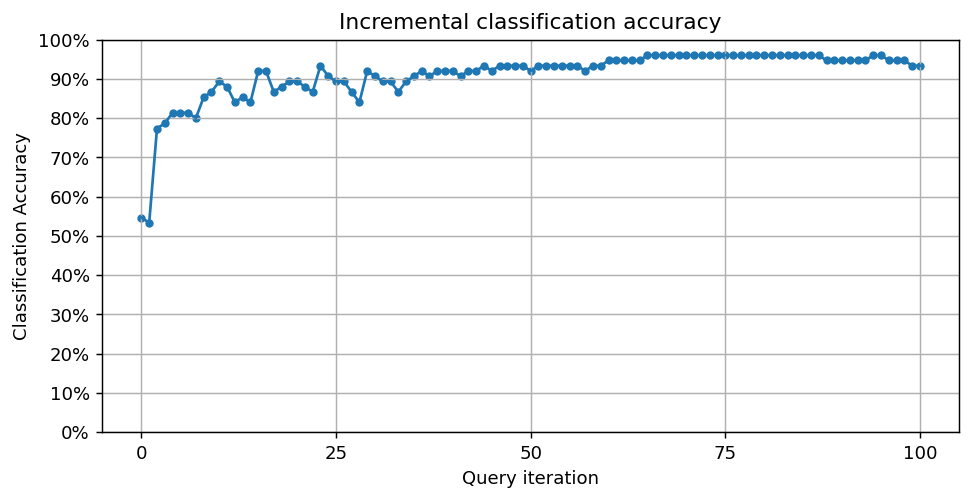

In [1838]:
plot_acc(qbc_perf_hist10pc)

### 20%

In [1839]:
init_committee20pc = make_committee(startDat5, 0.2)
qbc_learner20pc, qbc_perf_hist20pc, qbc_mse_hist20pc = run_qbc_al(init_committee20pc, pool, testDat, 0.2)

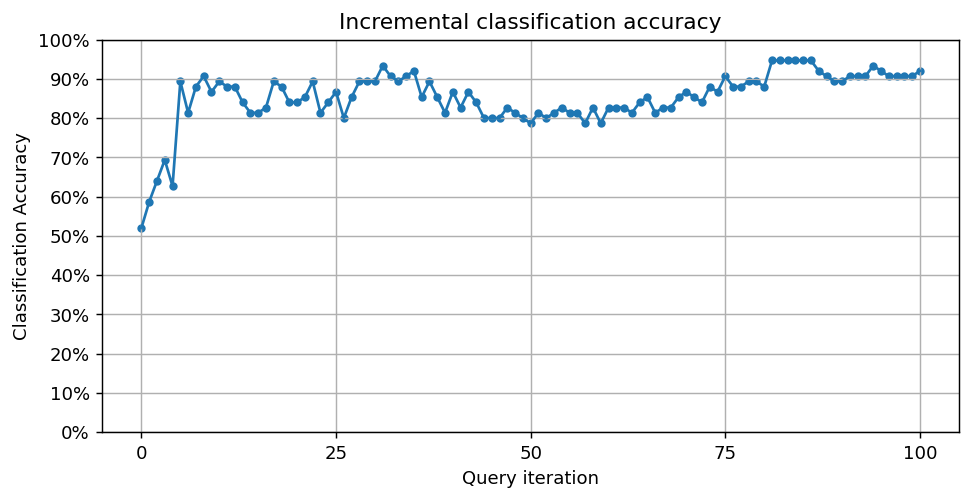

In [849]:
plot_acc(qbc_perf_hist20pc)

### 30 %

In [1840]:
init_committee30pc = make_committee(startDat5, 0.3)
qbc_learner30pc, qbc_perf_hist30pc, qbc_mse_hist30pc = run_qbc_al(init_committee30pc, pool, testDat, 0.3)

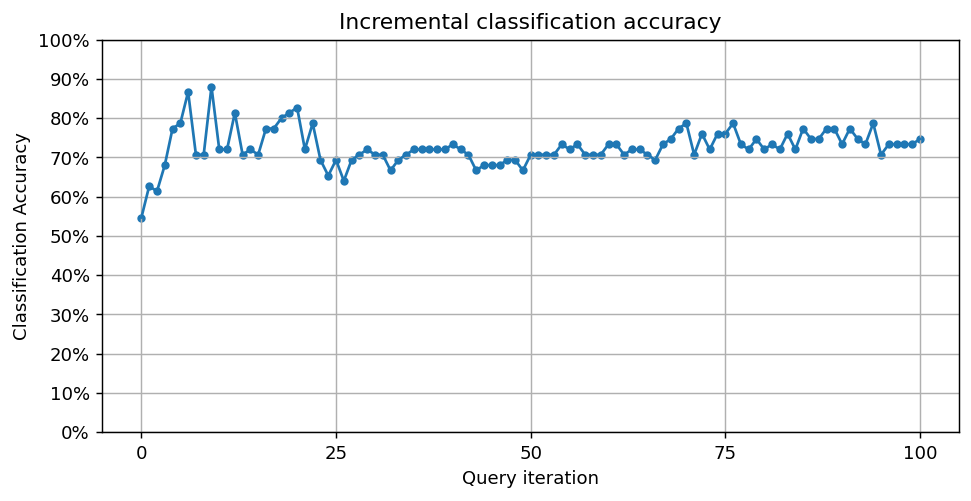

In [858]:
plot_acc(qbc_perf_hist30pc)

### 40%

In [1841]:
init_committee40pc = make_committee(startDat5, 0.4)
qbc_learner40pc, qbc_perf_hist40pc, qbc_mse_hist40pc = run_qbc_al(init_committee40pc, pool, testDat, 0.4)

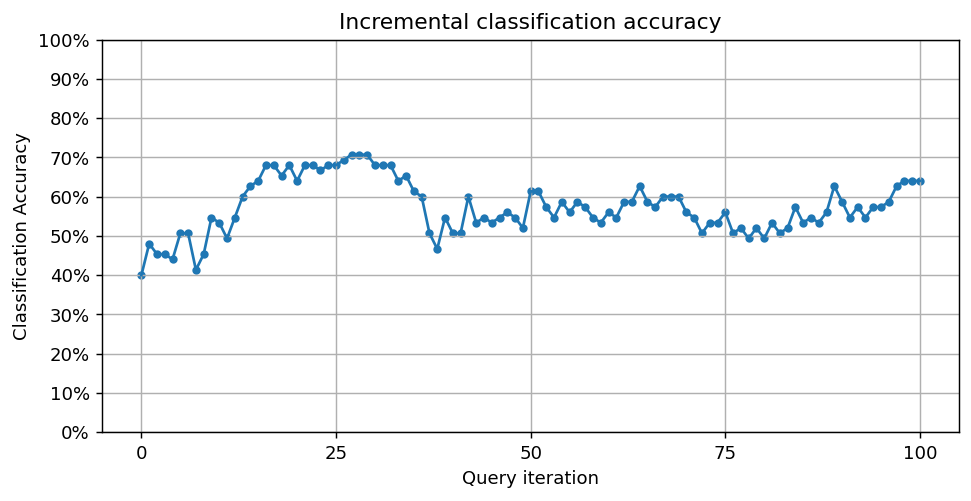

In [860]:
plot_acc(qbc_perf_hist40pc)

### 50%

In [1842]:
init_committee50pc = make_committee(startDat5, 0.5)
qbc_learner50pc, qbc_perf_hist50pc, qbc_mse_hist50pc = run_qbc_al(init_committee30pc, pool, testDat, 0.5)

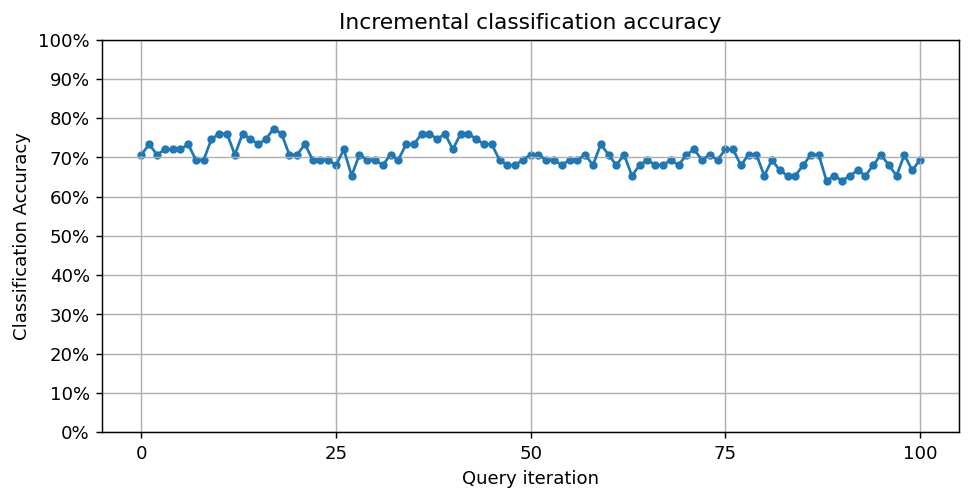

In [868]:
plot_acc(qbc_perf_hist50pc)

## Imbalanced

In [1912]:
init_committeeImb = make_committeeImb(startDat5, 0)
qbc_learnerImb, qbc_perf_histImb, qbc_mse_histImb, qbc_mcc_histImb = run_qbc_alImb(init_committeeImb, pool, testDat, 0)

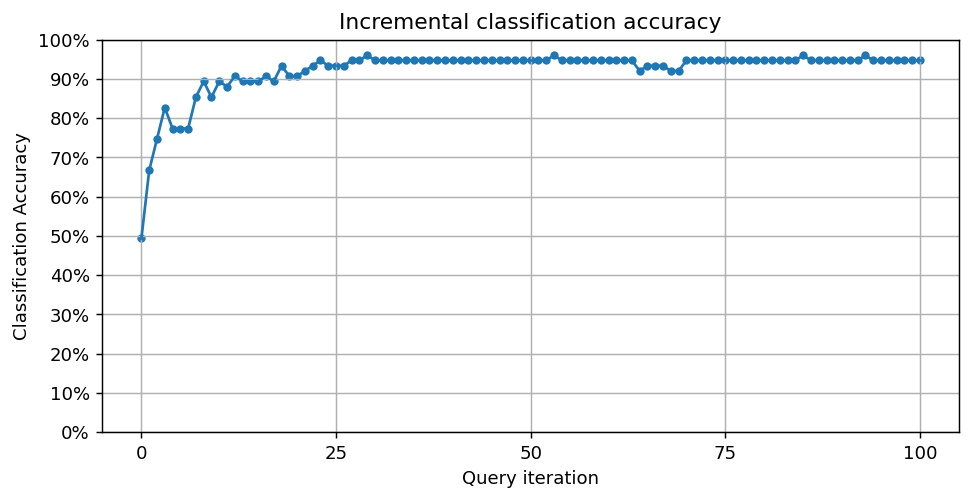

In [1793]:
plot_acc(qbc_perf_histImb)

# LTS - no reg

In [1914]:
def run_lts_al(starting_learner, starting_regressor, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    learner = starting_learner
    regressor = starting_regressor
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        uncertainties = regressor.predict(t_pool)
        query_index = np.random.choice(range(len(t_pool)), p=softmax(uncertainties))
        query_instance = t_pool[query_index]
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle2D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)
        regressor.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    return learner, perf_hist, mse_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

In [1915]:
def run_lts_alImb(starting_learner, starting_regressor, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    learner = starting_learner
    regressor = starting_regressor
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        uncertainties = regressor.predict(t_pool)
        query_index = np.random.choice(range(len(t_pool)), p=softmax(uncertainties))
        query_instance = t_pool[query_index]
        newX, newY = [t_pool[int(query_index)]], [noisy_oracleImb2D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)
        regressor.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [1742]:
init_learner5 = ActiveLearner(svm, X_training=startDat5, y_training=ystartDat5)
lts_reg_learner = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner5, startDat5))
lts_learner, lts_perf_hist, lts_mse_hist = run_lts_al(init_learner5, lts_reg_learner, pool, testDat, 0)

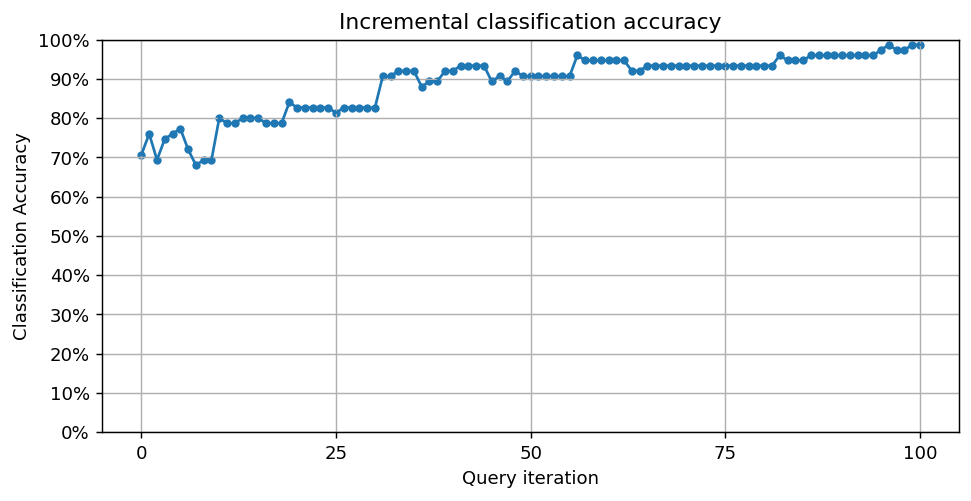

In [1138]:
plot_acc(lts_perf_hist)

## Noise

### 10%

In [1540]:
init_learner510pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.1) for i in startDat5])
lts_reg_learner10pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner510pc, startDat5))
lts_learner10pc, lts_perf_hist10pc, lts_mse_hist10pc = run_lts_al(init_learner510pc, lts_reg_learner10pc, pool, testDat, 0.1)

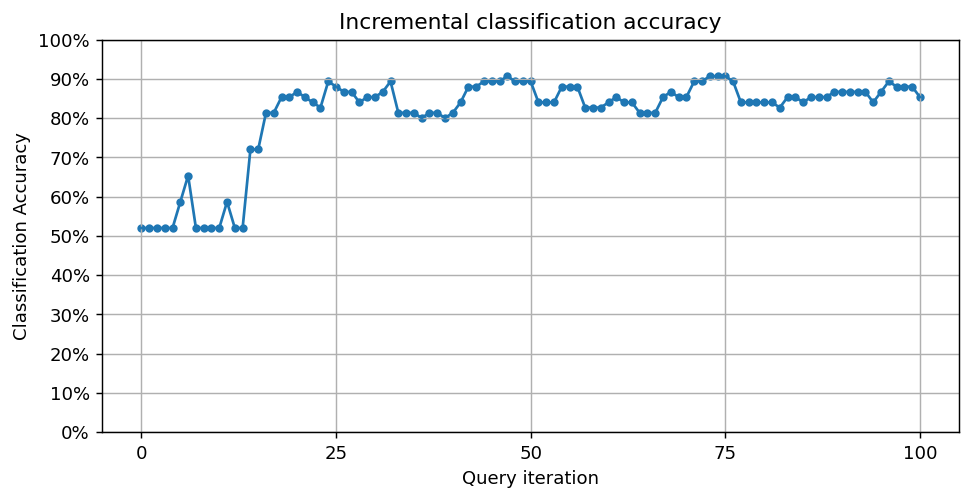

In [1142]:
plot_acc(lts_perf_hist10pc)

### 20%

In [1541]:
init_learner520pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.2) for i in startDat5])
lts_reg_learner20pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner520pc, startDat5))
lts_learner20pc, lts_perf_hist20pc, lts_mse_hist20pc = run_lts_al(init_learner520pc, lts_reg_learner20pc, pool, testDat, 0.2)

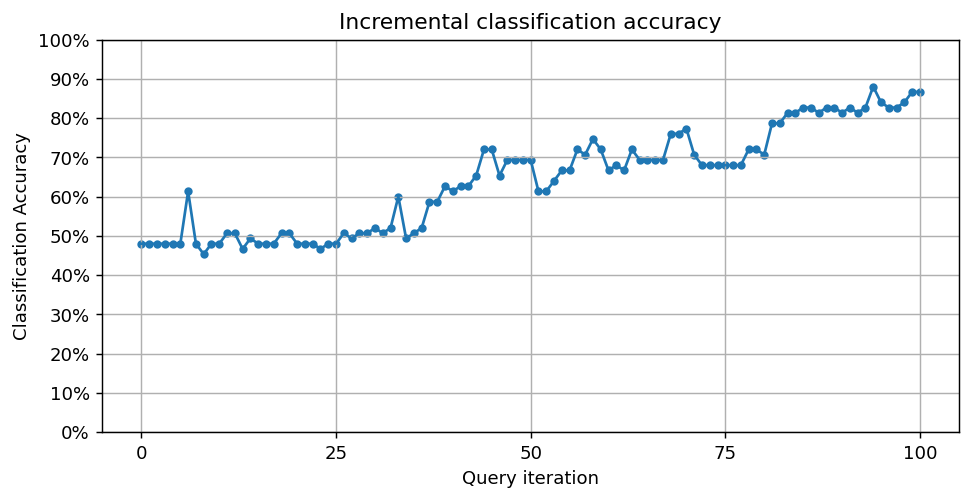

In [1144]:
plot_acc(lts_perf_hist20pc)

### 30%

In [1542]:
init_learner530pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.3) for i in startDat5])
lts_reg_learner30pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner530pc, startDat5))
lts_learner30pc, lts_perf_hist30pc, lts_mse_hist30pc = run_lts_al(init_learner530pc, lts_reg_learner30pc, pool, testDat, 0.3)

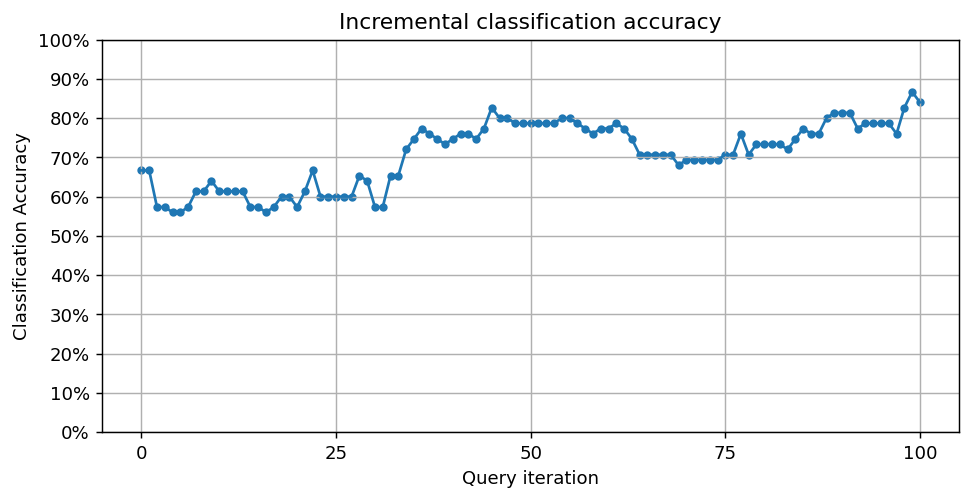

In [1146]:
plot_acc(lts_perf_hist30pc)

### 40%

In [1543]:
init_learner540pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.4) for i in startDat5])
lts_reg_learner40pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner540pc, startDat5))
lts_learner40pc, lts_perf_hist40pc, lts_mse_hist40pc = run_lts_al(init_learner540pc, lts_reg_learner40pc, pool, testDat, 0.4)

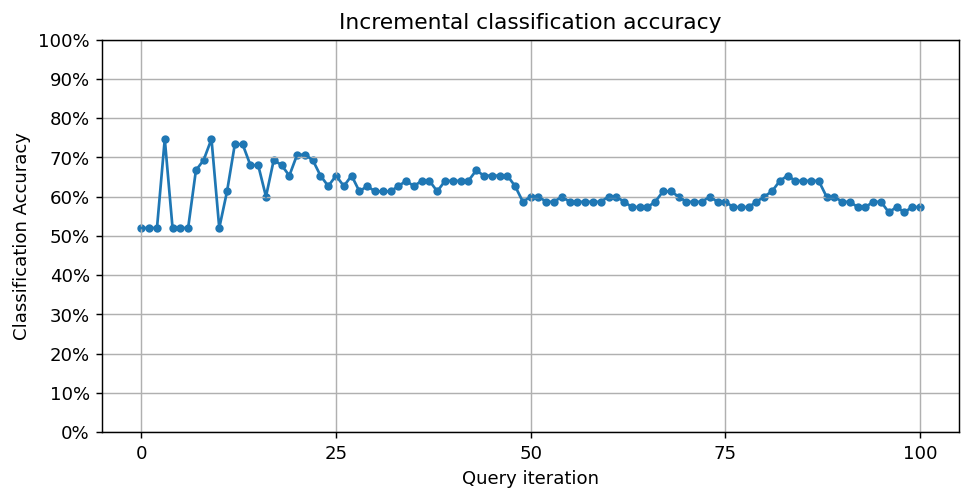

In [1148]:
plot_acc(lts_perf_hist40pc)

### 50%

In [1544]:
init_learner550pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.5) for i in startDat5])
lts_reg_learner50pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner550pc, startDat5))
lts_learner50pc, lts_perf_hist50pc, lts_mse_hist50pc = run_lts_al(init_learner550pc, lts_reg_learner50pc, pool, testDat, 0.5)

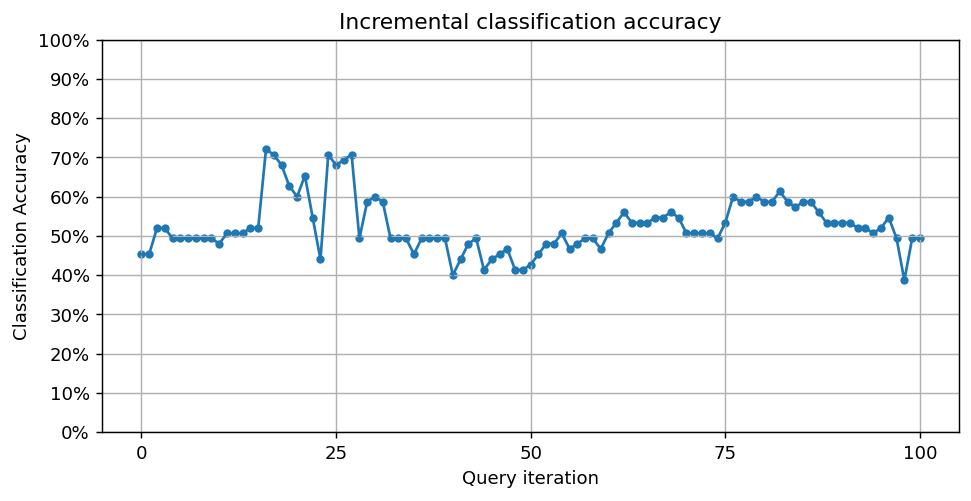

In [1150]:
plot_acc(lts_perf_hist50pc)

## Imbalanced

In [1916]:
init_learner5Imb = ActiveLearner(svm, X_training=startDat5, y_training=[pbI2Imbppts(i) for i in startDat5])
lts_reg_learnerImb = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner5Imb, startDat5))
lts_learnerImb, lts_perf_histImb, lts_mse_histImb, lts_mcc_histImb = run_lts_alImb(init_learner5Imb, lts_reg_learnerImb, pool, testDat, 0)

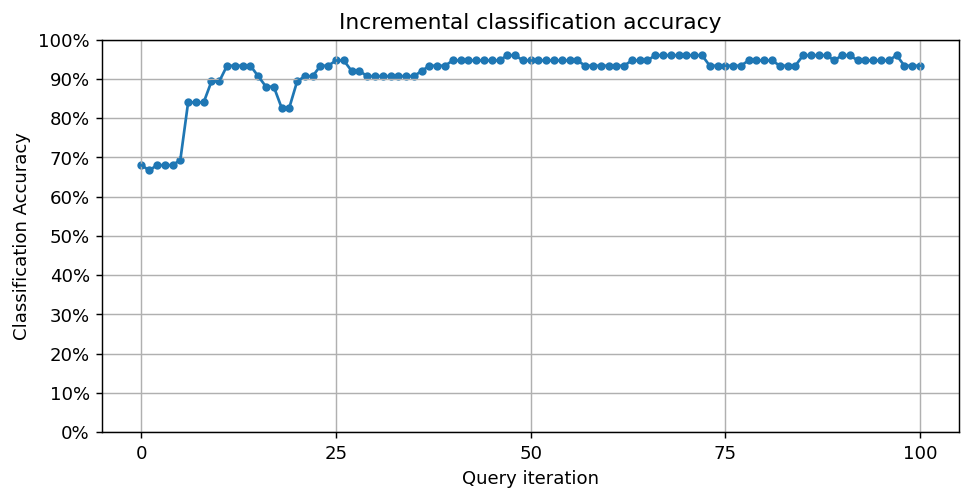

In [1796]:
plot_acc(lts_perf_histImb)

# LTSR

In [1743]:
def run_ltsr_al(starting_learner, starting_regressor, clusterer, pool_data, test_data, noise_pc, alpha, num_queries=100):
    t_pool = pool_data[:]
    clust1 = []
    clust2 = []
    clust3 = []
    clust4 = []
    clust5 = []
    clust6 = []
    clust7 = []
    for i in t_pool:
        if kmeans.predict(i.reshape(1, -1))[0] == 0:
            clust1.append(i)
        elif kmeans.predict(i.reshape(1, -1))[0] == 1:
            clust2.append(i)
        elif kmeans.predict(i.reshape(1, -1))[0] == 2:
            clust3.append(i)
    clusts = [clust1, clust2, clust3, clust4, clust5, clust6, clust7]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    learner = starting_learner
    regressor = starting_regressor
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        uncertainties = regressor.predict(t_pool)
        regs = [sum(np.linalg.norm(clusts[clusterer.predict(i.reshape(1, -1))[0]], axis=1)) for i in t_pool]
        zipped = zip(uncertainties, regs)
        weights = [x + alpha*y for (x, y) in zipped]

        query_index = np.random.choice(range(len(t_pool)), p=softmax(weights))
        query_instance = t_pool[query_index]
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle2D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)
        regressor.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    return learner, perf_hist, mse_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

In [1917]:
def run_ltsr_alImb(starting_learner, starting_regressor, clusterer, pool_data, test_data, noise_pc, alpha, num_queries=100):
    t_pool = pool_data[:]
    clust1 = []
    clust2 = []
    clust3 = []
    for i in t_pool:
        if kmeans.predict(i.reshape(1, -1))[0] == 0:
            clust1.append(i)
        elif kmeans.predict(i.reshape(1, -1))[0] == 1:
            clust2.append(i)
        elif kmeans.predict(i.reshape(1, -1))[0] == 2:
            clust3.append(i)
    clusts = [clust1, clust2, clust3]

    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    learner = starting_learner
    regressor = starting_regressor
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        uncertainties = regressor.predict(t_pool)
        regs = [sum(np.linalg.norm(clusts[clusterer.predict(i.reshape(1, -1))[0]], axis=1)) for i in t_pool]
        zipped = zip(uncertainties, regs)
        weights = [x + alpha*y for (x, y) in zipped]

        query_index = np.random.choice(range(len(t_pool)), p=softmax(weights))
        query_instance = t_pool[query_index]
        newX, newY = [t_pool[int(query_index)]], [noisy_oracleImb2D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)
        regressor.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [1744]:
kmeans = KMeans(n_clusters=3).fit(pool)
init_learner5 = ActiveLearner(svm, X_training=startDat5, y_training=ystartDat5)
ltsr_reg_learner = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner5, startDat5))
ltsr_learner, ltsr_perf_hist, ltsr_mse_hist = run_ltsr_al(init_learner5, ltsr_reg_learner, kmeans, pool, testDat, 0, 1.5)

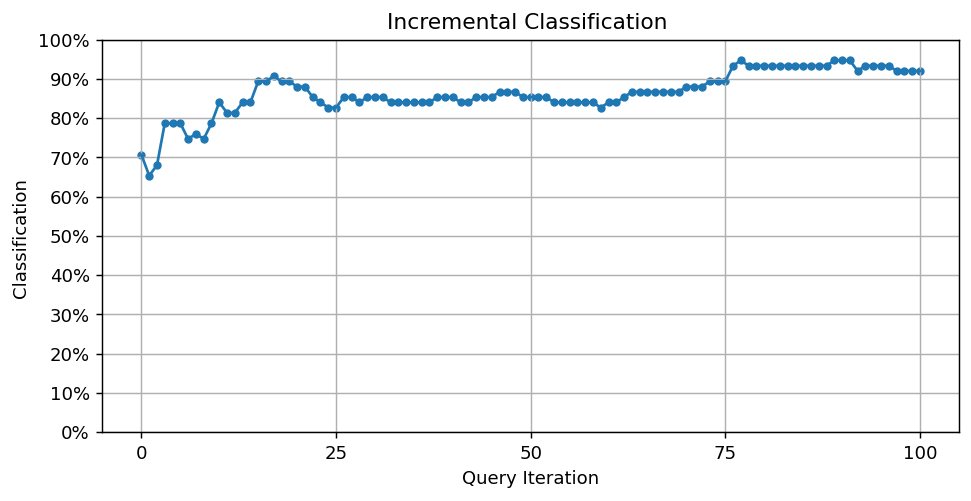

In [1716]:
plot_metric(ltsr_perf_hist)

## Noise

### 10%

In [1663]:
kmeans10pc = KMeans(n_clusters=3).fit(pool)
init_learner510pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.1) for i in startDat5])
ltsr_reg_learner10pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner510pc, startDat5))
ltsr_learner10pc, ltsr_perf_hist10pc, ltsr_mse_hist10pc = run_ltsr_al(init_learner510pc, ltsr_reg_learner10pc, kmeans10pc, pool, testDat, 0.1, 1.5)

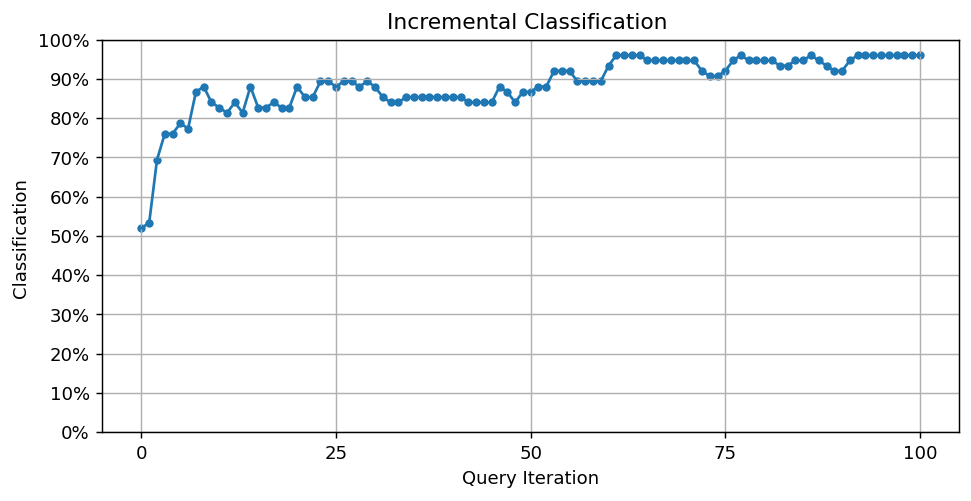

In [1664]:
plot_metric(ltsr_perf_hist10pc)

### 20%

In [1665]:
kmeans20pc = KMeans(n_clusters=3).fit(pool)
init_learner520pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.2) for i in startDat5])
ltsr_reg_learner20pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner520pc, startDat5))
ltsr_learner20pc, ltsr_perf_hist20pc, ltsr_mse_hist20pc = run_ltsr_al(init_learner520pc, ltsr_reg_learner20pc, kmeans20pc, pool, testDat, 0.1, 1.5)

### 30%

In [1666]:
kmeans30pc = KMeans(n_clusters=3).fit(pool)
init_learner530pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.3) for i in startDat5])
ltsr_reg_learner30pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner530pc, startDat5))
ltsr_learner30pc, ltsr_perf_hist30pc, ltsr_mse_hist30pc = run_ltsr_al(init_learner530pc, ltsr_reg_learner30pc, kmeans30pc, pool, testDat, 0.3, 1.5)

### 40%

In [1667]:
kmeans40pc = KMeans(n_clusters=3).fit(pool)
init_learner540pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.4) for i in startDat5])
ltsr_reg_learner40pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner540pc, startDat5))
ltsr_learner40pc, ltsr_perf_hist40pc, ltsr_mse_hist40pc = run_ltsr_al(init_learner540pc, ltsr_reg_learner40pc, kmeans40pc, pool, testDat, 0.4, 1.5)

### 50%

In [1668]:
kmeans50pc = KMeans(n_clusters=3).fit(pool)
init_learner550pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.5) for i in startDat5])
ltsr_reg_learner50pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner550pc, startDat5))
ltsr_learner50pc, ltsr_perf_hist50pc, ltsr_mse_hist50pc = run_ltsr_al(init_learner550pc, ltsr_reg_learner50pc, kmeans50pc, pool, testDat, 0.5, 1.5)

## Imbalanced

In [1918]:
kmeansImb = KMeans(n_clusters=3).fit(pool)
init_learner5Imb = ActiveLearner(svm, X_training=startDat5, y_training=[pbI2Imbppts(i) for i in startDat5])
ltsr_reg_learnerImb = ActiveLearner(estimator=LinearRegression(), X_training=startDat5, y_training=classifier_uncertainty(init_learner5Imb, startDat5))
ltsr_learnerImb, ltsr_perf_histImb, ltsr_mse_histImb, ltsr_mcc_histImb = run_ltsr_alImb(init_learner5Imb, ltsr_reg_learnerImb, kmeansImb, pool, testDat, 0, 1.5)

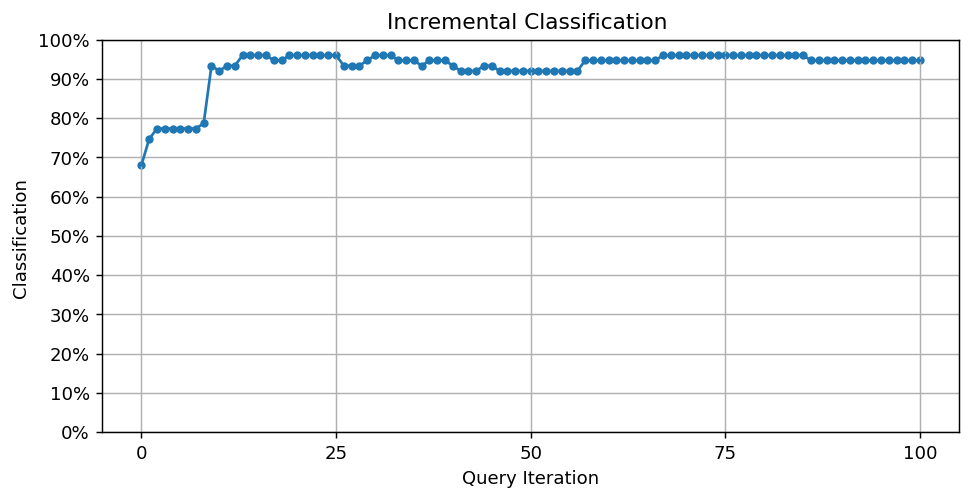

In [1799]:
plot_metric(ltsr_perf_histImb)

# LTSNN

In [1061]:
# the mathematica net was: 
#NetChain[{LinearLayer[15], BatchNormalizationLayer[], 
#   ElementwiseLayer[Ramp], LinearLayer[10], BatchNormalizationLayer[],
#    LinearLayer[1], ElementwiseLayer[Ramp]}, "Input" -> 2, 
#  "Output" -> "Scalar"];

In [17]:
#def nn_regressor():
 #   nn_model = Sequential()
  #  nn_model.add(Dense(12, kernel_initializer='normal', activation='relu'))
   # nn_model.add(Dense(8, activation='linear'))
    #nn_model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    #nn_model.add(BatchNormalization())
    #nn_model.add(Dense(1, activation='relu'))

    #nn_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']);
    #return nn_model
    #del nn_model


In [96]:
def nn_regressor():
    nn_model = Sequential()
    nn_model.add(Dense(12, activation='relu', input_shape=[2]))
    nn_model.add(Dense(8, activation='linear'))
    nn_model.add(Dense(4, activation='relu'))
    nn_model.add(BatchNormalization())
    nn_model.add(Dense(1, activation='relu'))

    nn_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return nn_model
    del nn_model

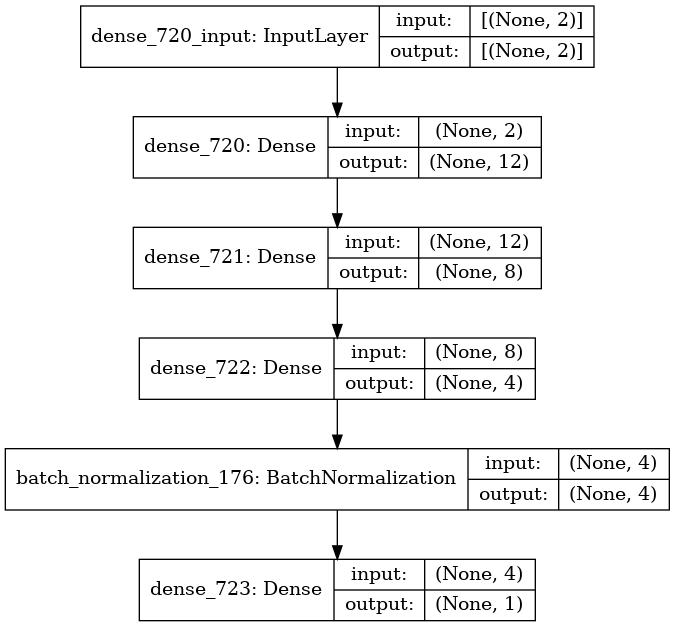

In [114]:
model = Sequential()
model.add(Dense(12, activation='relu', input_shape=[2]))
model.add(Dense(8, activation='linear'))
model.add(Dense(4, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [98]:
def run_ltsnn_al(starting_learner, starting_regressor, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    learner = starting_learner
    regressor = starting_regressor
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        uncertainties = regressor.predict(t_pool)
        query_index = np.random.choice(range(len(t_pool)), p=softmax(uncertainties))
        query_instance = t_pool[query_index]
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle2D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)
        regressor.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
    t_pool = pool_data[:]
    t_ypool = [pbI2ppts(i) for i in t_pool]
    t_ytest = [pbI2ppts(i) for i in test_data]
    return learner, perf_hist, mse_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

In [99]:
def run_ltsnn_alImb(starting_learner, starting_regressor, pool_data, test_data, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    learner = starting_learner
    regressor = starting_regressor
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        uncertainties = regressor.predict(t_pool)
        query_index = np.random.choice(range(len(t_pool)), p=softmax(uncertainties))
        query_instance = t_pool[query_index]
        newX, newY = [t_pool[int(query_index)]], [pbI2Imbppts(t_pool[int(query_index)])]
        learner.teach(X=newX, y=newY)
        regressor.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [pbI2Imbppts(i) for i in t_pool]
    t_ytest = [pbI2Imbppts(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [108]:
init_learner5 = ActiveLearner(svm,X_training=startDat5, y_training=ystartDat5)
nn_init = KerasRegressor(nn_regressor)
nn_reg_init = ActiveLearner(
    estimator=nn_init,
    X_training=startDat5, y_training=classifier_uncertainty(init_learner5, startDat5)
)
ltsnn_learner, ltsnn_perf_hist, ltsnn_mse_hist = run_ltsnn_al(init_learner5, nn_reg_init, pool, testDat, 0)

4/4 [==============================] - 1s 2ms/step - loss: 0.4350 - mse: 0.4350 - mae: 0.4490


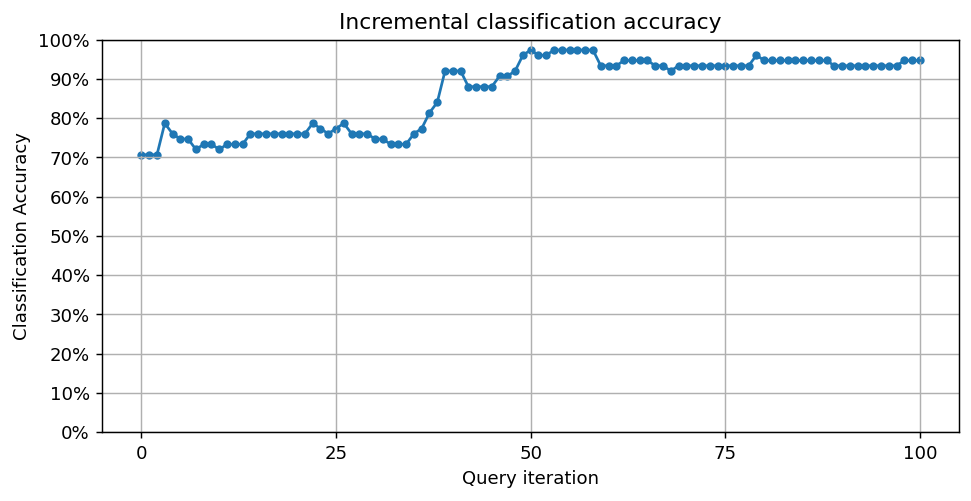

In [1174]:
plot_acc(ltsnn_perf_hist)

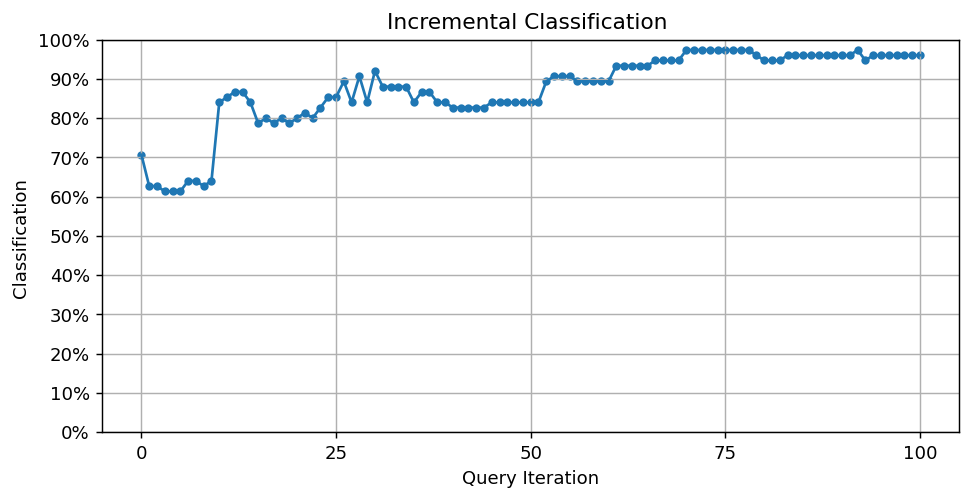

In [109]:
plot_metric(ltsnn_perf_hist)

## Noise

### 10%

In [1673]:
init_learner510pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.1) for i in startDat5])
nn_init10pc = KerasRegressor(nn_regressor)
nn_reg_init10pc = ActiveLearner(
    estimator=nn_init10pc,
    X_training=startDat5, y_training=classifier_uncertainty(init_learner510pc, startDat5)
)
ltsnn_learner10pc, ltsnn_perf_hist10pc, ltsnn_mse_hist10pc = run_lts_al(init_learner510pc, nn_reg_init10pc, pool, testDat, 0.1)

4/4 [==============================] - 1s 2ms/step - loss: 0.5084 - mse: 0.5084 - mae: 0.5171


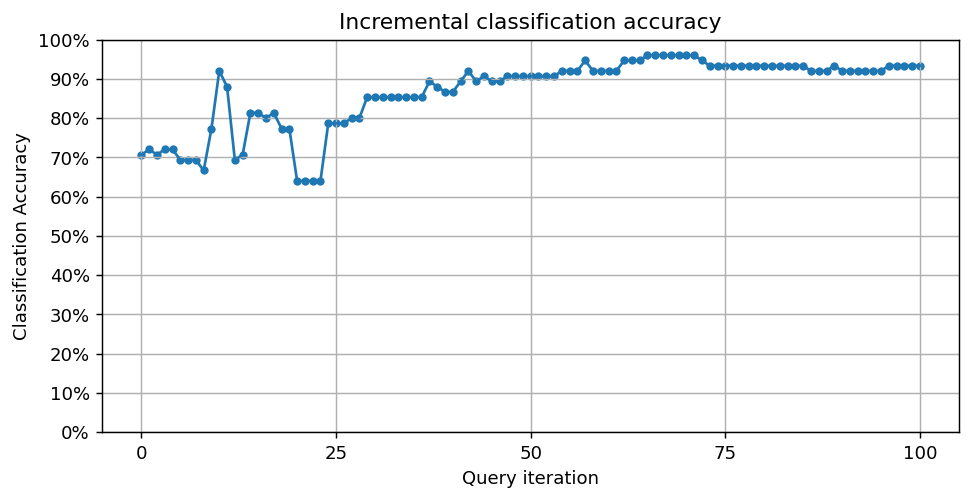

In [1180]:
plot_acc(ltsnn_perf_hist10pc)

### 20%

In [1674]:
init_learner520pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.2) for i in startDat5])
nn_init20pc = KerasRegressor(nn_regressor)
nn_reg_init20pc = ActiveLearner(
    estimator=nn_init20pc,
    X_training=startDat5, y_training=classifier_uncertainty(init_learner520pc, startDat5)
)
ltsnn_learner20pc, ltsnn_perf_hist20pc, ltsnn_mse_hist20pc = run_lts_al(init_learner520pc, nn_reg_init20pc, pool, testDat, 0.2)

4/4 [==============================] - 1s 2ms/step - loss: 0.5090 - mse: 0.5090 - mae: 0.5202


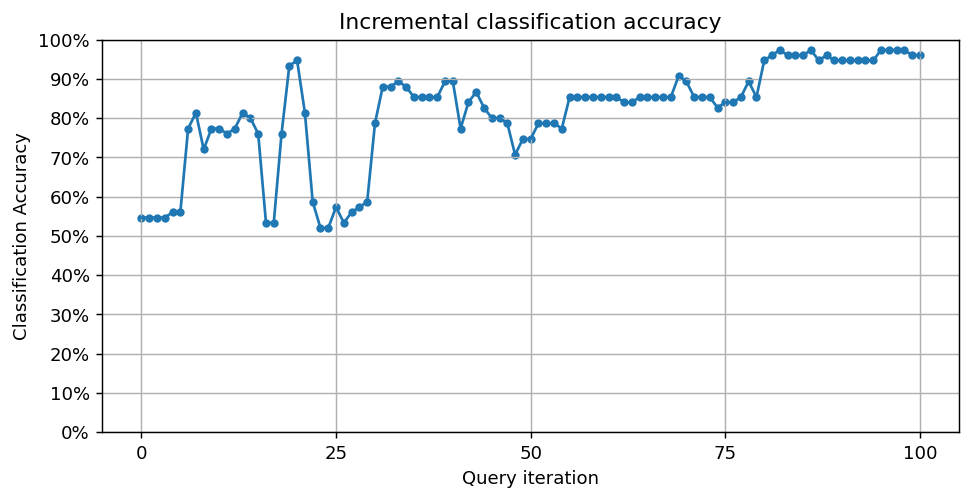

In [1183]:
plot_acc(ltsnn_perf_hist20pc)

### 30%

In [1675]:
init_learner530pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.3) for i in startDat5])
nn_init30pc = KerasRegressor(nn_regressor)
nn_reg_init30pc = ActiveLearner(
    estimator=nn_init30pc,
    X_training=startDat5, y_training=classifier_uncertainty(init_learner530pc, startDat5)
)
ltsnn_learner30pc, ltsnn_perf_hist30pc, ltsnn_mse_hist30pc = run_lts_al(init_learner530pc, nn_reg_init30pc, pool, testDat, 0.3)

4/4 [==============================] - 1s 2ms/step - loss: 0.4700 - mse: 0.4700 - mae: 0.4747


In [ ]:
plot_acc(ltsnn_perf_hist30pc)

### 40%

In [1676]:
init_learner540pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.4) for i in startDat5])
nn_init40pc = KerasRegressor(nn_regressor)
nn_reg_init40pc = ActiveLearner(
    estimator=nn_init40pc,
    X_training=startDat5, y_training=classifier_uncertainty(init_learner540pc, startDat5)
)
ltsnn_learner40pc, ltsnn_perf_hist40pc, ltsnn_mse_hist40pc = run_lts_al(init_learner540pc, nn_reg_init40pc, pool, testDat, 0.4)

4/4 [==============================] - 1s 2ms/step - loss: 0.5259 - mse: 0.5259 - mae: 0.5399


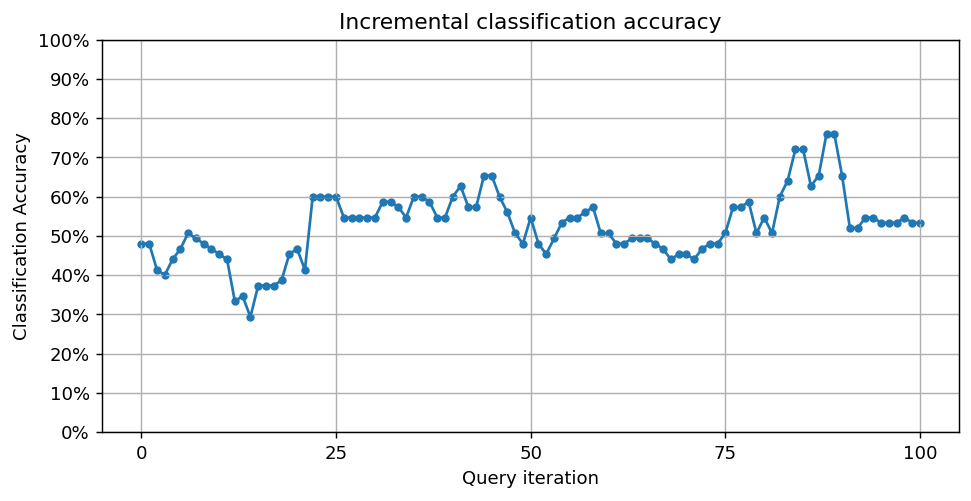

In [1186]:
plot_acc(ltsnn_perf_hist40pc)

### 50%

In [1677]:
init_learner550pc = ActiveLearner(svm, X_training=startDat5, y_training=[noisy_oracle2D(i, 0.5) for i in startDat5])
nn_init50pc = KerasRegressor(nn_regressor)
nn_reg_init50pc = ActiveLearner(
    estimator=nn_init50pc,
    X_training=startDat5, y_training=classifier_uncertainty(init_learner550pc, startDat5)
)
ltsnn_learner50pc, ltsnn_perf_hist50pc, ltsnn_mse_hist50pc = run_lts_al(init_learner550pc, nn_reg_init50pc, pool, testDat, 0.5)

4/4 [==============================] - 1s 2ms/step - loss: 0.4912 - mse: 0.4912 - mae: 0.5043


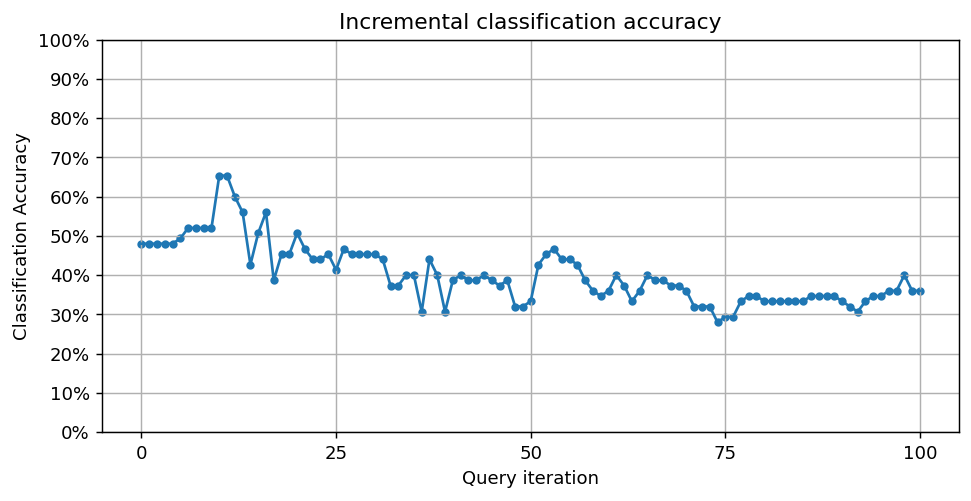

In [1188]:
plot_acc(ltsnn_perf_hist50pc)

## Imbalanced

In [1920]:
init_learner5Imb = ActiveLearner(svm, X_training=startDat5, y_training=[pbI2Imbppts(i) for i in startDat5])
nn_initImb = KerasRegressor(nn_regressor)
nn_reg_initImb = ActiveLearner(
    estimator=nn_initImb,
    X_training=startDat5, y_training=classifier_uncertainty(init_learner5Imb, startDat5)
)
ltsnn_learnerImb, ltsnn_perf_histImb, ltsnn_mse_histImb, ltsnn_mcc_histImb = run_lts_alImb(init_learner5Imb, nn_reg_initImb, pool, testDat, 0)

4/4 [==============================] - 1s 2ms/step - loss: 0.2603 - mse: 0.2603 - mae: 0.2659


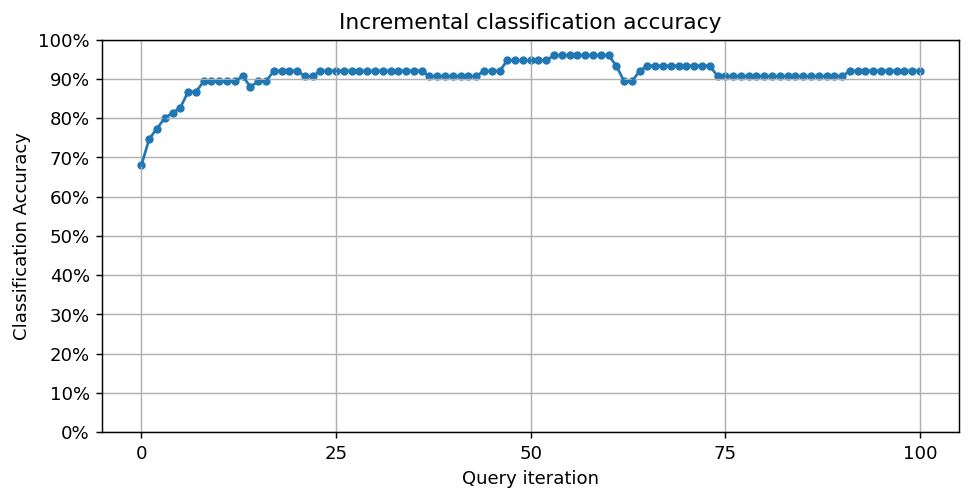

In [1306]:
plot_acc(ltsnn_perf_histImb)

# Analysis

## Noiseless

### Combined

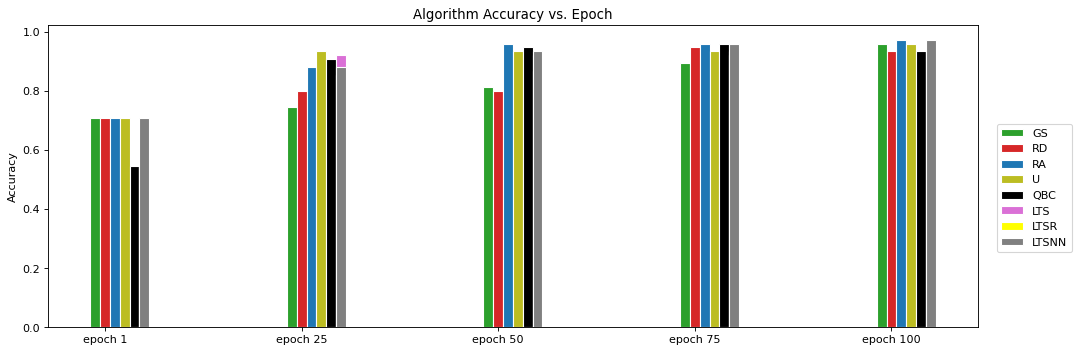

In [1750]:
plt.figure(figsize=(15, 5), dpi=80)

# set width of bars
barWidth = 0.05
 
#set heights of bars
gsBar = gs_perf_hist[0:125:25]
rdBar = rd_perf_hist[0:125:25]
raBar = ra_perf_hist[0:125:25]
uBar = u_perf_hist[0:125:25]
qbcBar = qbc_perf_hist[0:125:25]
ltsBar = lts_perf_hist[0:125:25]
ltsrBar = ltsr_perf_hist[0:125:25]
ltsnnBar = ltsnn_perf_hist[0:125:25]
 
# Set position of bar on X axis
r1 = np.arange(len(gsBar))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
 
# Make the plot
plt.bar(r1, gsBar, color='tab:green', width=barWidth, edgecolor='white', label='GS')
plt.bar(r2, rdBar, color='tab:red', width=barWidth, edgecolor='white', label='RD')
plt.bar(r3, raBar, color='tab:blue', width=barWidth, edgecolor='white', label='RA')
plt.bar(r4, uBar, color='tab:olive', width=barWidth, edgecolor='white', label='U')
plt.bar(r5, qbcBar, color='black', width=barWidth, edgecolor='white', label='QBC')
plt.bar(r6, ltsBar, color='orchid', width=barWidth, edgecolor='white', label='LTS')
plt.bar(r6, ltsrBar, color='yellow', width=barWidth, edgecolor='white', label='LTSR')
plt.bar(r6, ltsnnBar, color='gray', width=barWidth, edgecolor='white', label='LTSNN')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(gsBar))], ['epoch 1', 'epoch 25', 'epoch 50', 'epoch 75', 'epoch 100'])
 
# Create legend & Show graphic
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.02,0.25), loc="lower left", borderaxespad=0)
plt.title('Algorithm Accuracy vs. Epoch')
plt.show()

In [1754]:
barDat = [gsBar, rdBar, raBar, uBar, qbcBar, ltsBar, ltsrBar, ltsnnBar]

In [1755]:
np.savetxt('barDatError2D.txt', np.array(barDat))

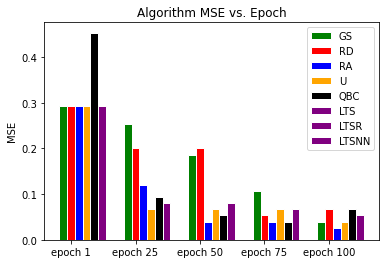

In [1753]:
# set width of bars
barWidth = 0.12
 
# set heights of bars
gsBar = gs_mse_hist[0:125:25]
rdBar = rd_mse_hist[0:125:25]
raBar = ra_mse_hist[0:125:25]
uBar = u_mse_hist[0:125:25]
qbcBar = qbc_mse_hist[0:125:25]
ltsBar = lts_mse_hist[0:125:25]
ltsrBar = ltsr_mse_hist[0:125:25]
ltsnnBar = ltsnn_mse_hist[0:125:25]
 
# Set position of bar on X axis
r1 = np.arange(len(gsBar))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r5]
r8 = [x + barWidth for x in r5]
 
# Make the plot
plt.bar(r1, gsBar, color='green', width=barWidth, edgecolor='white', label='GS')
plt.bar(r2, rdBar, color='red', width=barWidth, edgecolor='white', label='RD')
plt.bar(r3, raBar, color='blue', width=barWidth, edgecolor='white', label='RA')
plt.bar(r4, uBar, color='orange', width=barWidth, edgecolor='white', label='U')
plt.bar(r5, qbcBar, color='black', width=barWidth, edgecolor='white', label='QBC')
plt.bar(r6, ltsBar, color='purple', width=barWidth, edgecolor='white', label='LTS')
plt.bar(r7, ltsBar, color='purple', width=barWidth, edgecolor='white', label='LTSR')
plt.bar(r8, ltsBar, color='purple', width=barWidth, edgecolor='white', label='LTSNN')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(gsBar))], ['epoch 1', 'epoch 25', 'epoch 50', 'epoch 75', 'epoch 100'])
 
# Create legend & Show graphic
plt.ylabel('MSE')
plt.legend()
plt.title('Algorithm MSE vs. Epoch')
plt.show()

## Imbalanced

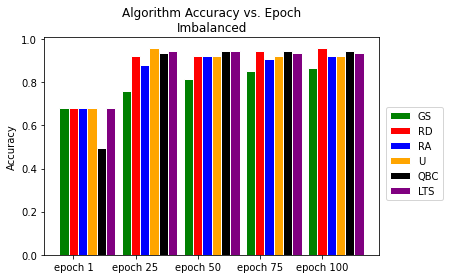

In [1806]:
# set width of bars
barWidth = 0.15
 
# set heights of bars
gsBar = gs_perf_histImb[0:125:25]
rdBar = rd_perf_histImb[0:125:25]
raBar = ra_perf_histImb[0:125:25]
uBar = u_perf_histImb[0:125:25]
qbcBar = qbc_perf_histImb[0:125:25]
ltsBar = lts_perf_histImb[0:125:25]
ltsrBar = ltsr_perf_histImb[0:125:25]
ltsnnBar = ltsnn_perf_histImb[0:125:25]
 
# Set position of bar on X axis
r1 = np.arange(len(gsBar))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
 
# Make the plot
plt.bar(r1, gsBar, color='green', width=barWidth, edgecolor='white', label='GS')
plt.bar(r2, rdBar, color='red', width=barWidth, edgecolor='white', label='RD')
plt.bar(r3, raBar, color='blue', width=barWidth, edgecolor='white', label='RA')
plt.bar(r4, uBar, color='orange', width=barWidth, edgecolor='white', label='U')
plt.bar(r5, qbcBar, color='black', width=barWidth, edgecolor='white', label='QBC')
plt.bar(r6, ltsBar, color='purple', width=barWidth, edgecolor='white', label='LTS')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(gsBar))], ['epoch 1', 'epoch 25', 'epoch 50', 'epoch 75', 'epoch 100'])
 
# Create legend & Show graphic
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.02,0.25), loc="lower left", borderaxespad=0)
plt.title('Algorithm Accuracy vs. Epoch\nImbalanced')
plt.show()

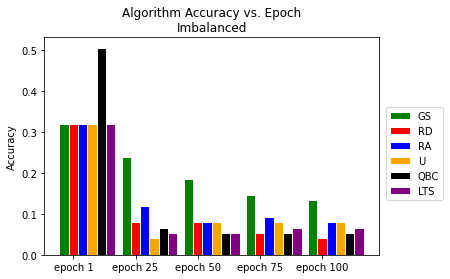

In [1809]:
# set width of bars
barWidth = 0.15
 
# set heights of bars
gsBar = gs_mse_histImb[0:125:25]
rdBar = rd_mse_histImb[0:125:25]
raBar = ra_mse_histImb[0:125:25]
uBar = u_mse_histImb[0:125:25]
qbcBar = qbc_mse_histImb[0:125:25]
ltsBar = lts_mse_histImb[0:125:25]
ltsrBar = ltsr_mse_histImb[0:125:25]
ltsnnBar = ltsnn_mse_histImb[0:125:25]
 
# Set position of bar on X axis
r1 = np.arange(len(gsBar))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
 
# Make the plot
plt.bar(r1, gsBar, color='green', width=barWidth, edgecolor='white', label='GS')
plt.bar(r2, rdBar, color='red', width=barWidth, edgecolor='white', label='RD')
plt.bar(r3, raBar, color='blue', width=barWidth, edgecolor='white', label='RA')
plt.bar(r4, uBar, color='orange', width=barWidth, edgecolor='white', label='U')
plt.bar(r5, qbcBar, color='black', width=barWidth, edgecolor='white', label='QBC')
plt.bar(r6, ltsBar, color='purple', width=barWidth, edgecolor='white', label='LTS')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(gsBar))], ['epoch 1', 'epoch 25', 'epoch 50', 'epoch 75', 'epoch 100'])
 
# Create legend & Show graphic
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.02,0.25), loc="lower left", borderaxespad=0)
plt.title('Algorithm Accuracy vs. Epoch\nImbalanced')
plt.show()

In [1921]:
gsBar = gs_mcc_histImb[0:125:25]
rdBar = rd_mcc_histImb[0:125:25]
raBar = ra_mcc_histImb[0:125:25]
uBar = u_mcc_histImb[0:125:25]
qbcBar = qbc_mcc_histImb[0:125:25]
ltsBar = lts_mcc_histImb[0:125:25]
ltsrBar = ltsr_mcc_histImb[0:125:25]
ltsnnBar = ltsnn_mcc_histImb[0:125:25]

In [1922]:
barDat = [gsBar, rdBar, raBar, uBar, qbcBar, ltsBar, ltsrBar, ltsnnBar]

In [1923]:
np.savetxt('barDatMCCImb2D.txt', np.array(barDat))

In [1813]:
imbClfs2D = [gs_learnerimb, rd_learnerImb, ra_learnerImb, u_learnerImb, qbc_learnerImb, lts_learnerImb, ltsr_learnerImb, ltsnn_learnerImb]

In [1814]:
[sklearn.metrics.matthews_corrcoef([pbI2Imbppts(i) for i in testDat], j.predict(testDat)) for j in imbClfs2D]

[0.8061389110926175,
 0.8061389110926175,
 0.8061389110926175,
 0.8061389110926175,
 0.847870182555781,
 0.8061389110926175,
 0.8061389110926175,
 0.8061389110926175]

## Noise

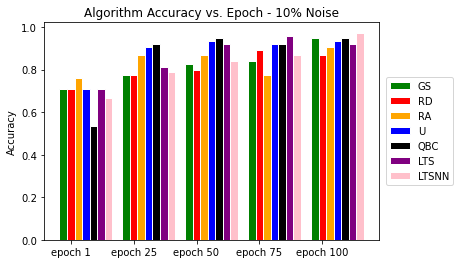

In [1815]:
# set width of bars
barWidth = 0.12
 
# set heights of bars
gsBar = gs_perf_hist10pc[0:125:25]
rdBar = rd_perf_hist10pc[0:125:25]
raBar = ra_perf_hist10pc[0:125:25]
uBar = u_perf_hist10pc[0:125:25]
qbcBar = qbc_perf_hist10pc[0:125:25]
ltsBar = lts_perf_hist10pc[0:125:25]
ltsnnBar = ltsnn_perf_hist10pc[0:125:25]
 
# Set position of bar on X axis
r1 = np.arange(len(gsBar))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
 
# Make the plot
plt.bar(r1, gsBar, color='green', width=barWidth, edgecolor='white', label='GS')
plt.bar(r2, rdBar, color='red', width=barWidth, edgecolor='white', label='RD')
plt.bar(r3, raBar, color='orange', width=barWidth, edgecolor='white', label='RA')
plt.bar(r4, uBar, color='blue', width=barWidth, edgecolor='white', label='U')
plt.bar(r5, qbcBar, color='black', width=barWidth, edgecolor='white', label='QBC')
plt.bar(r6, ltsBar, color='purple', width=barWidth, edgecolor='white', label='LTS')
plt.bar(r7, ltsnnBar, color='pink', width=barWidth, edgecolor='white', label='LTSNN')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(gsBar))], ['epoch 1', 'epoch 25', 'epoch 50', 'epoch 75', 'epoch 100'])
 
# Create legend & Show graphic
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.02,0.25), loc="lower left", borderaxespad=0)
plt.title('Algorithm Accuracy vs. Epoch - 10% Noise')
plt.show()

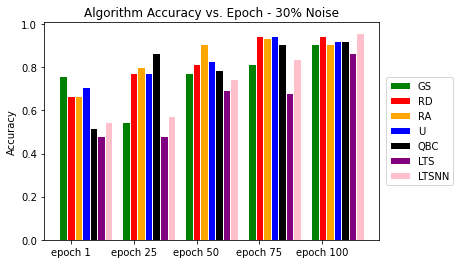

In [1452]:
# set width of bars
barWidth = 0.12
 
# set heights of bars
gsBar = gs_perf_hist20pc[0:125:25]
rdBar = rd_perf_hist20pc[0:125:25]
raBar = ra_perf_hist20pc[0:125:25]
uBar = u_perf_hist20pc[0:125:25]
qbcBar = qbc_perf_hist20pc[0:125:25]
ltsBar = lts_perf_hist20pc[0:125:25]
ltsnnBar = ltsnn_perf_hist20pc[0:125:25]
 
# Set position of bar on X axis
r1 = np.arange(len(gsBar))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
 
# Make the plot
plt.bar(r1, gsBar, color='green', width=barWidth, edgecolor='white', label='GS')
plt.bar(r2, rdBar, color='red', width=barWidth, edgecolor='white', label='RD')
plt.bar(r3, raBar, color='orange', width=barWidth, edgecolor='white', label='RA')
plt.bar(r4, uBar, color='blue', width=barWidth, edgecolor='white', label='U')
plt.bar(r5, qbcBar, color='black', width=barWidth, edgecolor='white', label='QBC')
plt.bar(r6, ltsBar, color='purple', width=barWidth, edgecolor='white', label='LTS')
plt.bar(r7, ltsnnBar, color='pink', width=barWidth, edgecolor='white', label='LTSNN')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(gsBar))], ['epoch 1', 'epoch 25', 'epoch 50', 'epoch 75', 'epoch 100'])
 
# Create legend & Show graphic
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.02,0.25), loc="lower left", borderaxespad=0)
plt.title('Algorithm Accuracy vs. Epoch - 30% Noise')
plt.show()

In [1873]:
gs_perf_hist10pc[0:125:25][3]

0.7866666666666666

In [1869]:
k = 75
accs75Noise = [[gs_perf_hist10pc[k], rd_perf_hist10pc[k], ra_perf_hist10pc[k], u_perf_hist10pc[k], qbc_perf_hist10pc[k], lts_perf_hist10pc[k], ltsr_perf_hist10pc[k], ltsnn_perf_hist10pc[k]], 
[gs_perf_hist20pc[k], rd_perf_hist20pc[k], ra_perf_hist20pc[k], u_perf_hist20pc[k], qbc_perf_hist20pc[k], lts_perf_hist20pc[k], ltsr_perf_hist20pc[k], ltsnn_perf_hist20pc[k]], 
[gs_perf_hist30pc[k], rd_perf_hist30pc[k], ra_perf_hist30pc[k], u_perf_hist30pc[k], qbc_perf_hist30pc[k], lts_perf_hist30pc[k], ltsr_perf_hist30pc[k], ltsnn_perf_hist30pc[k]], 
[gs_perf_hist40pc[k], rd_perf_hist40pc[k], ra_perf_hist40pc[k], u_perf_hist40pc[k], qbc_perf_hist40pc[k], lts_perf_hist40pc[k], ltsr_perf_hist40pc[k], ltsnn_perf_hist40pc[k]], 
[gs_perf_hist50pc[k], rd_perf_hist50pc[k], ra_perf_hist50pc[k], u_perf_hist50pc[k], qbc_perf_hist50pc[k], lts_perf_hist50pc[k], ltsr_perf_hist50pc[k], ltsnn_perf_hist50pc[k]]]

In [1874]:
k = 100
accs100Noise = [[gs_perf_hist10pc[k], rd_perf_hist10pc[k], ra_perf_hist10pc[k], u_perf_hist10pc[k], qbc_perf_hist10pc[k], lts_perf_hist10pc[k], ltsr_perf_hist10pc[k], ltsnn_perf_hist10pc[k]], 
[gs_perf_hist20pc[k], rd_perf_hist20pc[k], ra_perf_hist20pc[k], u_perf_hist20pc[k], qbc_perf_hist20pc[k], lts_perf_hist20pc[k], ltsr_perf_hist20pc[k], ltsnn_perf_hist20pc[k]], 
[gs_perf_hist30pc[k], rd_perf_hist30pc[k], ra_perf_hist30pc[k], u_perf_hist30pc[k], qbc_perf_hist30pc[k], lts_perf_hist30pc[k], ltsr_perf_hist30pc[k], ltsnn_perf_hist30pc[k]], 
[gs_perf_hist40pc[k], rd_perf_hist40pc[k], ra_perf_hist40pc[k], u_perf_hist40pc[k], qbc_perf_hist40pc[k], lts_perf_hist40pc[k], ltsr_perf_hist40pc[k], ltsnn_perf_hist40pc[k]], 
[gs_perf_hist50pc[k], rd_perf_hist50pc[k], ra_perf_hist50pc[k], u_perf_hist50pc[k], qbc_perf_hist50pc[k], lts_perf_hist50pc[k], ltsr_perf_hist50pc[k], ltsnn_perf_hist50pc[k]]]

In [1870]:
accs25Noise = [[gs_perf_hist10pc[25], rd_perf_hist10pc[25], ra_perf_hist10pc[25], u_perf_hist10pc[25], qbc_perf_hist10pc[25], lts_perf_hist10pc[25], ltsr_perf_hist10pc[25], ltsnn_perf_hist10pc[25]], 
[gs_perf_hist20pc[25], rd_perf_hist20pc[25], ra_perf_hist20pc[25], u_perf_hist20pc[25], qbc_perf_hist20pc[25], lts_perf_hist20pc[25], ltsr_perf_hist20pc[25], ltsnn_perf_hist20pc[25]], 
[gs_perf_hist30pc[25], rd_perf_hist30pc[25], ra_perf_hist30pc[25], u_perf_hist30pc[25], qbc_perf_hist30pc[25], lts_perf_hist30pc[25], ltsr_perf_hist30pc[25], ltsnn_perf_hist30pc[25]], 
[gs_perf_hist40pc[25], rd_perf_hist40pc[25], ra_perf_hist40pc[25], u_perf_hist40pc[25], qbc_perf_hist40pc[25], lts_perf_hist40pc[25], ltsr_perf_hist40pc[25], ltsnn_perf_hist40pc[25]], 
[gs_perf_hist50pc[25], rd_perf_hist50pc[25], ra_perf_hist50pc[25], u_perf_hist50pc[25], qbc_perf_hist50pc[25], lts_perf_hist50pc[25], ltsr_perf_hist50pc[25], ltsnn_perf_hist50pc[25]]]

In [1875]:
np.savetxt('accs100Noise.txt', np.array(accs100Noise))

# Figures

## Set-Up

In [1204]:
sdTrue = startDat5[[i for i, x in enumerate([pbI2ppts(i) for i in startDat5]) if x == 1]]
sdFalse = startDat5[[i for i, x in enumerate([pbI2ppts(i) for i in startDat5]) if x == 0]]

<ipython-input-1321-3fedc187089a>:5: RuntimeWarning: divide by zero encountered in double_scalars
  plt.plot(x, [sqrt((1.4*10**(-8))/i) for i in x])


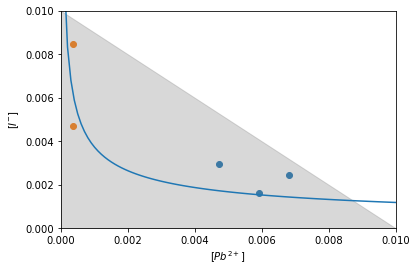

In [1321]:
plt.scatter(sdTrue[:,1], sdTrue[:,0])
plt.scatter(sdFalse[:,1], sdFalse[:,0])
x = np.linspace(0, 0.01, 100)

plt.plot(x, [sqrt((1.4*10**(-8))/i) for i in x])
plt.fill_between([0, 0.01], [0.01, 0], color='gray', alpha=0.3)
plt.xlim([0, 0.01])
plt.ylim([0, 0.01])
plt.xlabel('$[Pb^{2+}]$')
plt.ylabel('$[I^{-}]$')
plt.show()

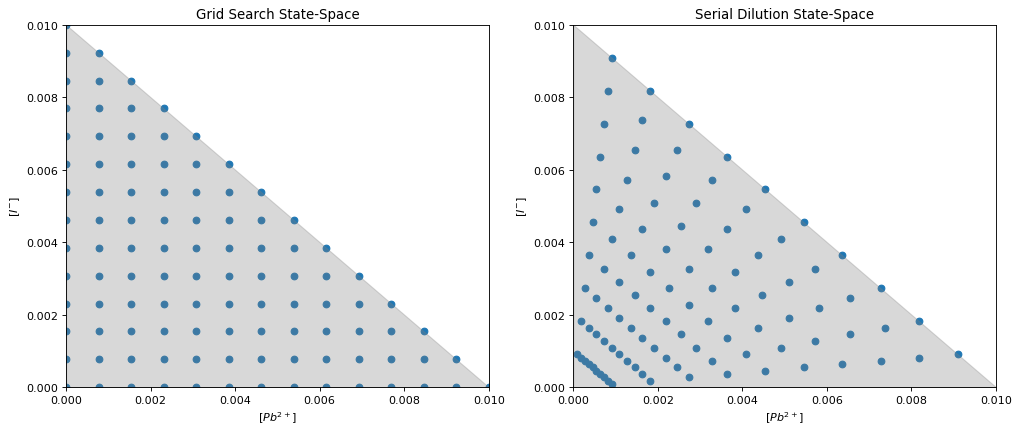

In [1274]:
plt.figure(figsize=(15, 6), dpi=80)

# GS Grid Set Up
plt.subplot(1, 2, 1) 
plt.scatter(gridDat2D[:,0], gridDat2D[:,1])
plt.fill_between([0, 0.01], [0.01, 0], color='gray', alpha=0.3)
plt.xlim([0, 0.01])
plt.ylim([0, 0.01])
plt.xlabel('$[Pb^{2+}]$')
plt.ylabel('$[I^{-}]$')
plt.title('Grid Search State-Space')

#SD Set Up
plt.subplot(1, 2, 2) 
plt.scatter(rayDat2D[:,0], rayDat2D[:,1])
plt.fill_between([0, 0.01], [0.01, 0], color='gray', alpha=0.3)
plt.xlim([0, 0.01])
plt.ylim([0, 0.01])
plt.xlabel('$[Pb^{2+}]$')
plt.ylabel('$[I^{-}]$')
plt.title('Serial Dilution State-Space')

plt.show()

## Decisions

In [1940]:
gs_model = gs_learner
rd_model = rd_learner
ra_model = ra_learner
u_model = u_learner
qbc_model = qbc_learner
lts_model = lts_learner
ltsr_model = ltsr_learner
ltsnn_model = ltsnn_learner

In [1942]:
classifiers = {
    "GS" : gs_model,
    "RD" : rd_model,
    "U" : u_model,
    "QBC" : qbc_model,
    "LTS" : lts_model,
    "LTSR" : ltsr_model,
    "LTSNN" : ltsnn_model
}

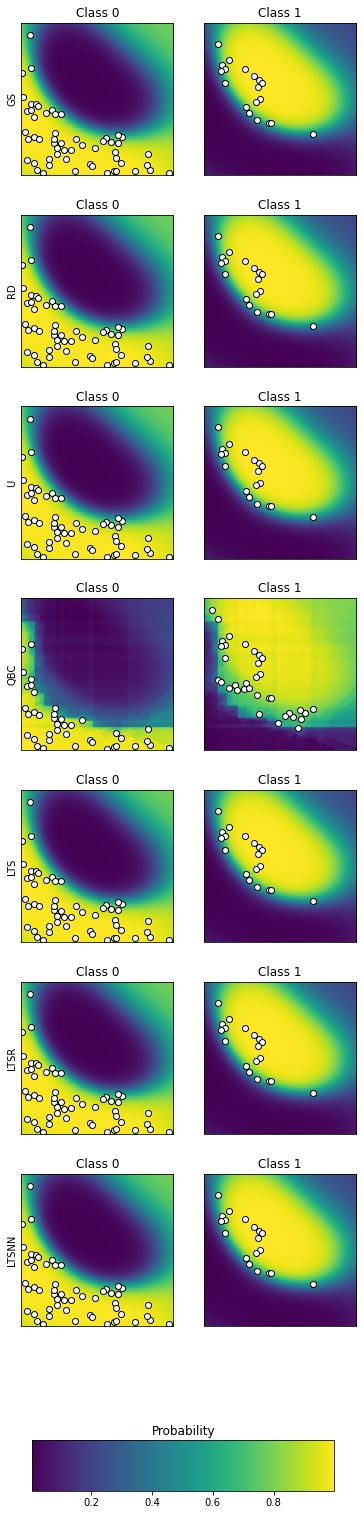

In [1963]:
n_classifiers = len(classifiers)

plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=1.5)

xx = np.linspace(0, 0.01, 100)
yy = np.linspace(0, 0.01, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]
X = testDat
y = ytest


for index, (name, classifier) in enumerate(classifiers.items()):

    y_pred = classifier.predict(X)

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(0, 0.01, 0, 0.01), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='w', edgecolor='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

#plt.savefig('boundaries2D.png', dpi=300, bbox_inches='tight')
plt.show()

In [1964]:
def make_committee_debug(starting_dat, noise_pc):
    l1 = ActiveLearner(svm, X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    l2 = ActiveLearner(KNeighborsClassifier(), X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    l3 = ActiveLearner(GaussianNB(), X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    l4 = ActiveLearner(RandomForestClassifier(), X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    l5 = ActiveLearner(DecisionTreeClassifier(), X_training=starting_dat, y_training=[noisy_oracle2D(i, noise_pc) for i in starting_dat])
    learner_list = [l1, l2, l3, l4, l5]
    return learner_list
    del l1, l2, l3, l4, l5, learner_list

In [1969]:
initCommitteeClfs = make_committee_debug(startDat5, 0)
classifiers = {
    "SVM" : initCommitteeClfs[0],
    "KNN" : initCommitteeClfs[1],
    "GNB" : initCommitteeClfs[2],
    "RF" : initCommitteeClfs[3],
    "DT" : initCommitteeClfs[4],
}